# Computer Vision 2022: Assignment 2

Authors: Louis Gauthy and Thomas Bahne \
Inspirations taken from https://www.kaggle.com/code/gauravsharma99/facial-emotion-recognition

## 1) Imports

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as matplot
import tensorflow as tf
from tensorflow import keras
import torch
import torchvision
import seaborn as sns
import cv2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score

Emotion encoding:
- 0: anger
- 1: disgust
- 2: fear
- 3: happiness
- 4: sadness
- 5: surprise
- 6: neutral

## 2) Loading the images, encoding labels

In [2]:
def one_hot_encoder(label:int, num_labels:int) -> np.ndarray:
    """Takes a numeric label value and returns the corresponding one-hot-encoding vector given the number of labels.
    Labels need to start from zero with step size 1.
    Example: if there are label {0,1,2}, so num_labels=3. Then the method will transform {1} into [0,1,0].
    Example: if there are labels {0,5,9} the method will not work as the labels do not have step size 1 between them.

    Args:
        label (int): label to be transformed into a one-hot-encoding vector
        num_labels (int): number of labels in total

    Returns:
        np.ndarray: one-hot-encoding vector
    """    
    one_hot_vector = np.zeros(num_labels)
    one_hot_vector[label] = 1
    return one_hot_vector

In [3]:
df = pd.read_csv('archive/fer2013/fer2013/fer2013.csv')
num_emotions = df.emotion.value_counts().shape[0]

df_train = df[df['Usage']=='Training'].drop(labels=['Usage'], axis=1)
df_val = df[df['Usage']=='PublicTest'].drop(labels=['Usage'], axis=1)
df_test = df[df['Usage']=='PrivateTest'].drop(labels=['Usage'], axis=1)

X_train = df_train.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
X_train = np.stack(X_train, axis=0)/255
y_train = df_train.emotion.apply(lambda x: one_hot_encoder(x, num_labels=num_emotions))
y_train = np.stack(y_train, axis=0)
X_val = df_val.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
X_val = np.stack(X_val, axis=0)/255
y_val = df_val.emotion.apply(lambda x: one_hot_encoder(x, num_labels=num_emotions))
y_val = np.stack(y_val, axis=0)
X_test = df_test.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
X_test = np.stack(X_test, axis=0)/255
y_test = df_test.emotion.apply(lambda x: one_hot_encoder(x, num_labels=num_emotions))
y_test = np.stack(y_test, axis=0)

print(f'Shape of X_train, y_train: {X_train.shape}, {y_train.shape}')
print(f'Shape of X_val, y_val: {X_val.shape}, {y_val.shape}')
print(f'Shape of X_test, y_test: {X_test.shape}, {y_test.shape}', end='')

Shape of X_train, y_train: (28709, 48, 48, 1), (28709, 7)
Shape of X_val, y_val: (3589, 48, 48, 1), (3589, 7)
Shape of X_test, y_test: (3589, 48, 48, 1), (3589, 7)

## 3) Implement augmentation method

Some samples when applying the image augmentation


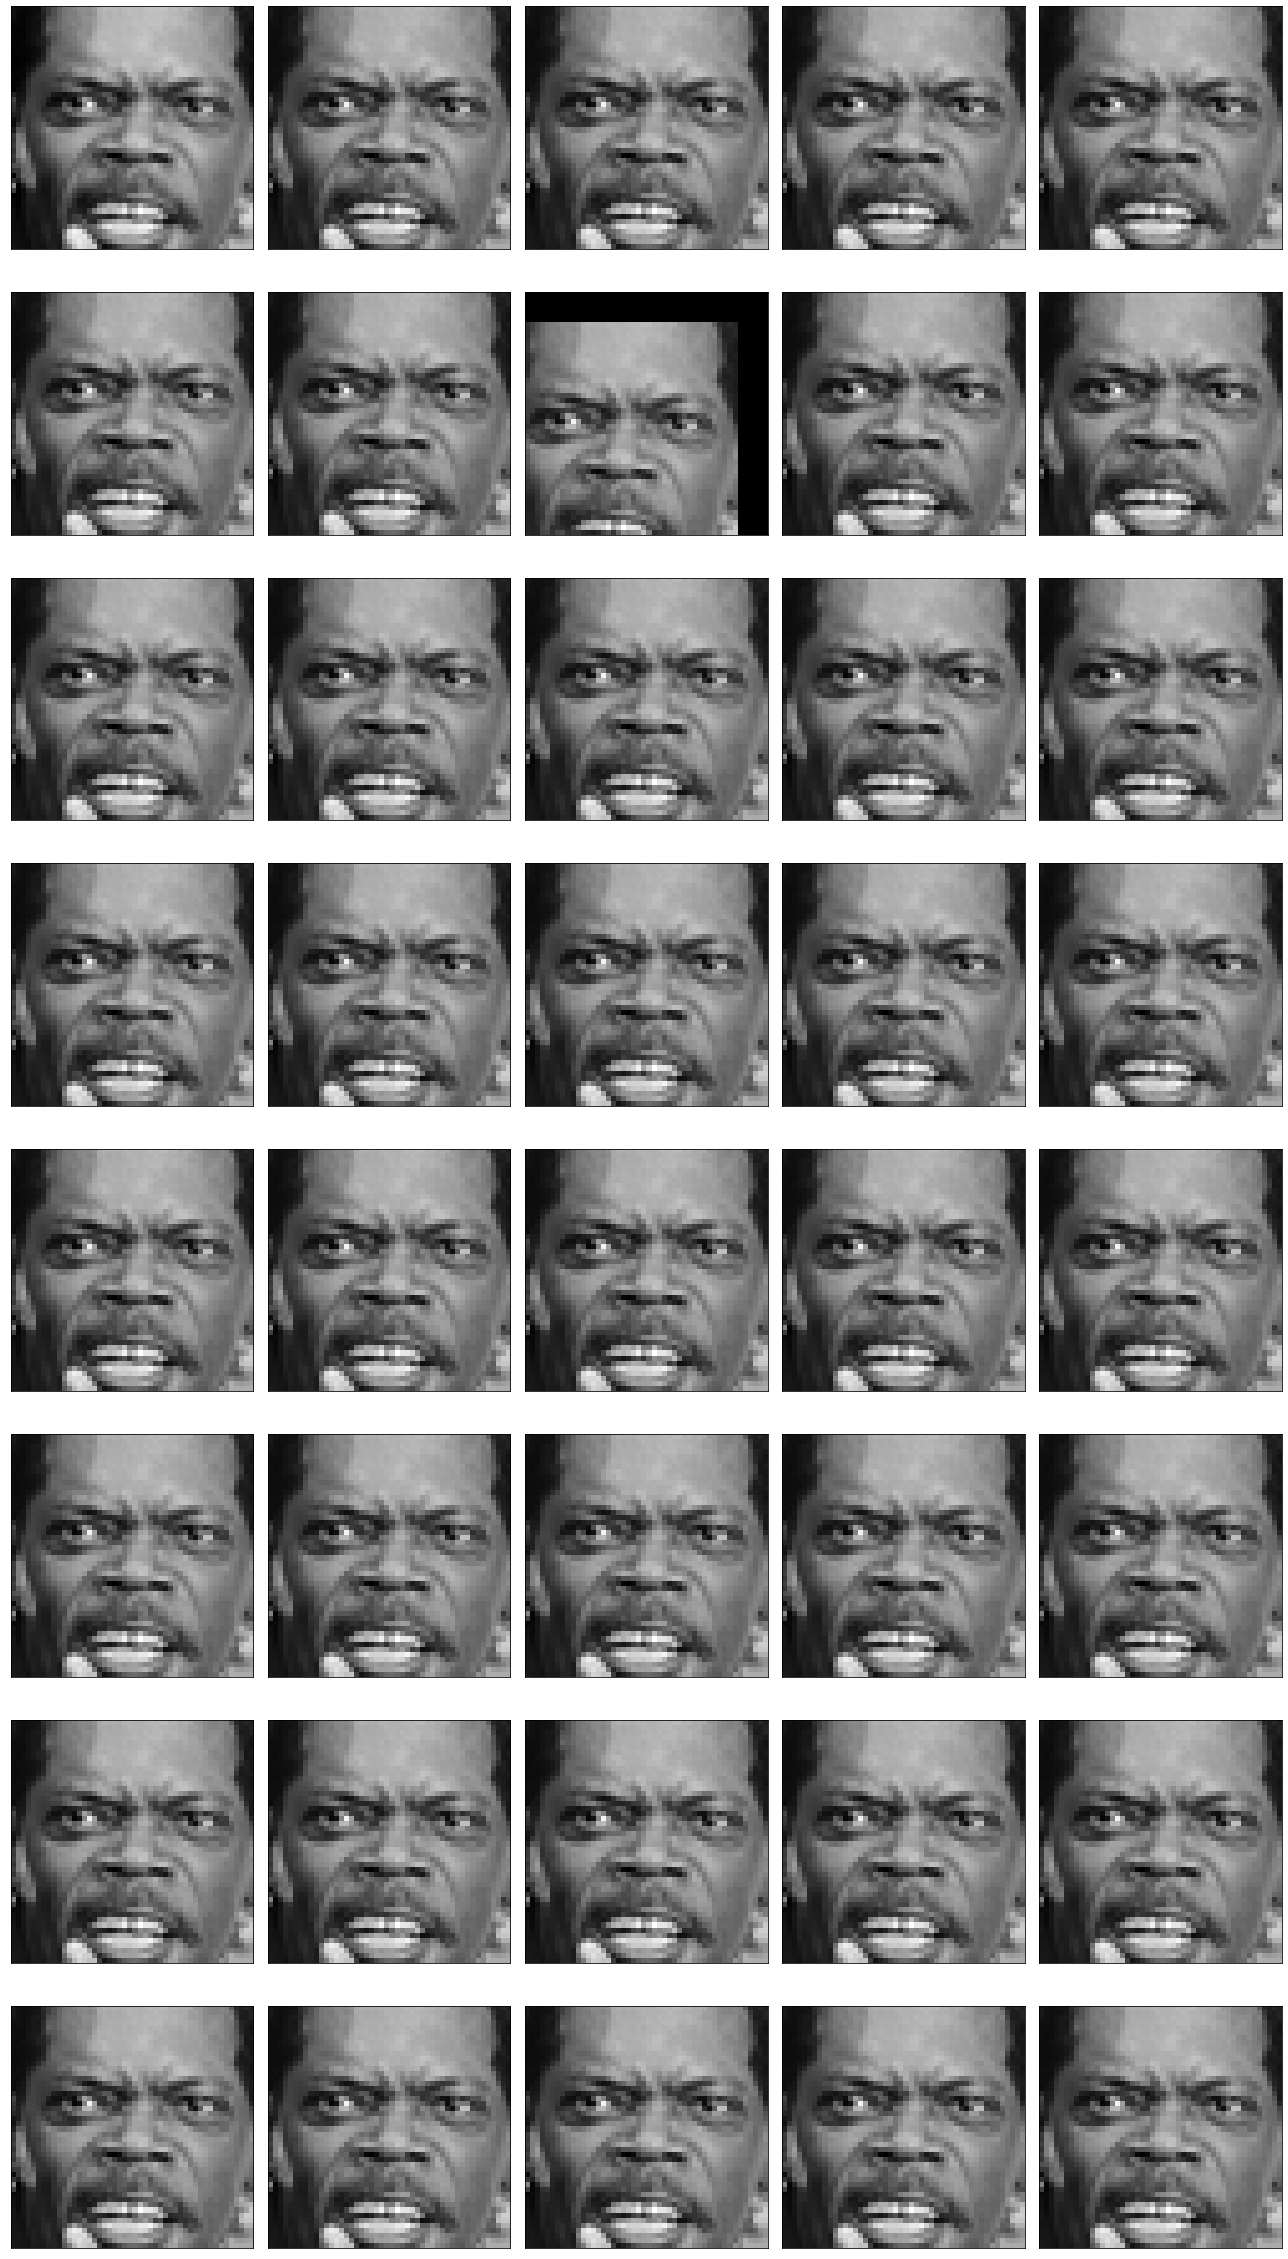

In [6]:
# decided to use the pytorch RandAugment() method as it does exactly what we want
def augment_image(image:np.ndarray):
    prob_for_augmentation = 0.1
    if np.random.random() < prob_for_augmentation:
        transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.ConvertImageDtype(dtype=torch.uint8),
            torchvision.transforms.RandAugment()
        ])
        augmented_image = transform((image*255).astype(np.uint8))
        return np.rollaxis(augmented_image.numpy(), axis=0, start=3)/255
    else: return image

image_augmenter = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=augment_image)

# testing to see what outputs the augment_image method returns
# on average, one for every (1/prob_for_augmentation) images will be transformed

print('Some samples when applying the image augmentation. On average, every 10th image should be augmented.')
fig = plt.figure(figsize=(18, 32))
for i in range(40):
    ax = plt.subplot(8, 5, i+1)
    ax.imshow(augment_image(X_train[10]), cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

## 4) Define model and training routine methods

In [7]:
def create_model(**kwargs) -> tf.keras.Model:
    """creates a keras model which has the architecture pre-specified. 
    The hyperparameters for the model can be passed as keyword arguments and will be used by the model.
    Which parameters can be specified as keyword arguments can be inferred from the "params" dictionary declared in this method.
    In order to adapt for entirely different archtictures, you might want to add further items to the "params" dictionary to allow
    the method to specify the additional (or new) hyper parameters.

    Returns:
        tf.keras.Model: compiled keras model
    """    
    # define default parameter values if not otherwise specified through inputs
    params={'learning_rate': 0.005, 
            'num_convBlocks': 2, 'filters': [16, 32], 'kernel_sizes': [3, 3], 'strides': [(1,1), (1,1)], 'pool_sizes': [(2,2), (2,2)],
            'dense_units': 16, 'dropout': 0}
    for key, value in kwargs.items():
        if key in params:
            params[key] = value

    assert params['num_convBlocks'] >= 1, 'Model needs to have at least one convolutional block to work.'
    assert params['num_convBlocks'] <= 5, 'Specified too many convolutional blocks, will downsample the image too much.'
    assert (params['num_convBlocks'] == len(params['filters'])) & \
            (params['num_convBlocks'] == len(params['kernel_sizes'])) & \
            (params['num_convBlocks'] == len(params['strides'])) & \
            (params['num_convBlocks'] == len(params['pool_sizes'])), 'Specified number of convolutional blocks does not match the number of parameters.'

    model = keras.models.Sequential()

    model.add(keras.layers.Conv2D(filters=params['filters'][0], kernel_size=params['kernel_sizes'][0],
                                    strides=params['strides'][0], activation='relu', padding='same', input_shape=(48,48,1), data_format='channels_last'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D(pool_size=params['pool_sizes'][0], strides=(2,2)))
    model.add(keras.layers.Dropout(rate=0.3))

    for i in range(params['num_convBlocks']-1):
        model.add(keras.layers.Conv2D(filters=params['filters'][i+1], kernel_size=params['kernel_sizes'][i+1], strides=params['strides'][i+1], padding='same', activation='relu'))
        model.add(keras.layers.MaxPool2D(pool_size=params['pool_sizes'][i+1], strides=(2,2)))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Dropout(rate=0.3))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(units=params['dense_units'], activation='relu'))
    # model.add(keras.layers.BatchNormalization())
    # model.add(keras.layers.Dropout(rate=params['dropout']))
    model.add(keras.layers.Dense(units=7, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    return model

In [8]:
# early stopping might need adaptation depending on how the convergence behavior of the model
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True, min_delta=0)

def train_model(epochs:int=100, batch_size:int=64, plot_loss:bool=True, run_on_mac:bool=False, **kwargs):
    """Trains a keras model with architecture specified in the create_model() method.
    Values for hyper parameters that should be used to build the model can be passed as keyword arguments
    or as a dictionary (compare create_model() method to see which ones are available).
    Parameters for the training of the model can be passed directly as inputs to this method.

    Args:
        epochs (int, optional): Maximum number of epochs to train, if early stopping does not cause earlier termination. Defaults to 500.
        batch_size (int, optional): size of a single batch. Defaults to 64.
        plot_loss (bool, optional): whether or not to plot a loss curve at the end of training. Defaults to True.
        run_on_mac (bool, optional): only set to true if you are using a mac and want to utilize its CPU instead of GPU. Defaults to False.

    Returns:
        tf.keras.Model, tf.keras.callbacks.History: returns the trained model and the training history
    """    

    model_params = ['num_convBlocks', 'learning_rate', 'filters', 'kernel_sizes', 'strides', 'pool_sizes', 'dense_units', 'dropout']
    model_kwargs = {}
    for key, value in kwargs.items():
        if key in model_params:
            model_kwargs[key] = value
    
    model = create_model(**model_kwargs)

    image_augmenter = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=augment_image)
    image_augmenter.fit(X_train)

    if run_on_mac:
        with tf.device('/cpu:0'): # only added this because the code runs quicker on my cpu than on my gpu
            history = model.fit(
                    image_augmenter.flow(X_train, y_train, batch_size=batch_size), 
                    validation_data=(X_val, y_val), 
                    steps_per_epoch=len(X_train)//batch_size,
                    validation_steps = len(X_test)//batch_size, epochs=epochs, 
                    callbacks=[early_stopping], use_multiprocessing=False,
                    batch_size=batch_size
                )
    else:
        history = model.fit(
                image_augmenter.flow(X_train, y_train, batch_size=batch_size), 
                validation_data=(X_val, y_val), 
                steps_per_epoch=len(X_train)//batch_size, 
                validation_steps = len(X_test)//batch_size, epochs=epochs, 
                callbacks=[early_stopping], use_multiprocessing=False,
                batch_size=batch_size
            )

    if plot_loss:
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'], '--')
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper right')
        plt.show()

    test_accuracy = np.round(model.evaluate(x=X_test, y=y_test, workers=12, use_multiprocessing=False, verbose=0)[1], 6)
    print(f'Accuracy on test set: {test_accuracy}')

    return model, history

Testing if the method works

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 48, 48, 16)        160       
                                                                 
 batch_normalization_5 (Batc  (None, 48, 48, 16)       64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 24, 24, 16)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 24, 24, 16)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 12, 12, 32)      

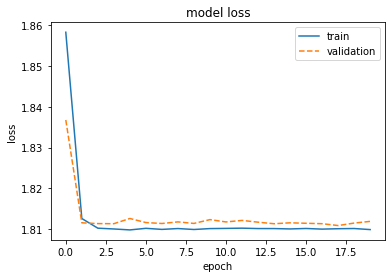

Accuracy on test set: 0.244915


In [10]:
model, history = train_model(epochs=20, run_on_mac=False)

In [14]:
def test_parameter_values(param_name:str, values:list, semilogx:bool=False, **kwargs) -> dict:
    """Runs the train_model() routine for different values of the specified parameter.

    Args:
        param_name (str): name of the parameter to be tested
        values (list): values to be tested for the parameter
        semilogx (bool, optional): whether to scale the x axis of the plot logarithmically. Defaults to False.

    Returns:
        dict: dictionary containing the name of the tested parameter, the tested values and corresponding accuracy scores on the test set.
    """    

    params={'epochs':500, 'batch_size':64, 'plot_loss':True,
            'learning_rate': 0.001, 
            'num_convBlocks': 2, 'filters': [64, 64], 'kernel_sizes': [3, 3], 'strides': [(1,1), (1,1)], 'pool_sizes': [(3,3), (3,3)],
            'dense_units': 16, 'dropout': 0}

    param_names={'epochs':'epochs', 'batch_size':'batch size', 'plot_loss':True,
            'learning_rate': 'learning rate', 
            'num_convBlocks': '# convolutional blocks (Conv2D, BatchNorm, Pooling)', 'filters': 'filters', 'kernel_sizes': 'kernel sizes', 'strides': 'stride lengths', 'pool_sizes': 'pooling size',
            'dense_units': '# dense units', 'dropout': 'dropout probability'}

    for key, value in kwargs.items():
        if key in params:
            params[key] = value
    
    test_accuracies = []
    for value in values:
        params[param_name] = value
        model, history = train_model(**params)
        test_accuracy = np.round(model.evaluate(x=X_test, y=y_test, workers=12, use_multiprocessing=False, verbose=0)[1], 6)   
        test_accuracies.append(test_accuracy)
        
    figure = plt.figure(figsize=(8,12))
    plt.plot(values, test_accuracies)
    if semilogx:
        plt.semilogx()
    plt.title(str(f'Validation Accuracy of different values for {param_name}'))
    plt.xlabel(param_names[param_name])
    plt.ylabel("Validation Accuracy Score")

    return {'parameter name': param_name, 'values':values, 'val_accuracies':test_accuracies}

In [15]:
def test_model_specifications(parameter_dicts:list) -> list:
    """Given a list dictionary, where each contains a parameter specifications for a model, the method trains one model for each specification 
    and returns the accuracy scores on the test set

    Args:
        parameter_dicts (list): dictionaries that each contain a set of parameter values for the CNN

    Returns:
        list: test accuracies for each parameter specification
    """    
    
    test_accuracies = []
    for params in parameter_dicts:
        model, history = train_model(**params)
        test_accuracy = np.round(model.evaluate(x=X_test, y=y_test, workers=12, use_multiprocessing=False, verbose=0)[1], 6)   
        test_accuracies.append(test_accuracy)
        
    return test_accuracies


def plot_accuracy_for_parameter(param_name:str, values:list, parameter_dicts:dict, semilogx:bool=False) -> dict:
    """Trains models for a set of parameter specifications and plots the evolution of test accuracy scores for the different specifications.
    Only works to alter one parameter per call.

    Args:
        param_name (str): name of the parameter that is to be tested.
        values (list): list of values to test for that parameter. Only used for annotating the graph.
        parameter_dicts (dict): parameter specification for the network (needs to include the parameter to be tested.)
        semilogx (bool, optional): Whether to do a log-transform on the x-axis of the plot. Defaults to False.

    Returns:
        dict: dictionary specifying the tested parameter values and accuracy scores.
    """    
    
    test_accuracies = test_model_specifications(parameter_dicts)

    param_names={'epochs':'epochs', 'batch_size':'batch size', 'plot_loss':True,
        'learning_rate': 'learning rate', 
        'num_convBlocks': '# convolutional blocks (Conv2D, BatchNorm, Pooling)', 'filters': 'filters', 'kernel_sizes': 'kernel sizes', 'strides': 'stride lengths', 'pool_sizes': 'pooling size',
        'dense_units': '# dense units', 'dropout': 'dropout probability'}

    figure = plt.figure(figsize=(8,12))
    plt.plot(values, test_accuracies)
    if semilogx:
        plt.semilogx()
    plt.title(str(f'Test Accuracy of different values for {param_names[param_name]}'))
    plt.xlabel(param_names[param_name])
    plt.ylabel("Test Accuracy Score")

    return {'parameter name': param_name, 'values':values, 'test_accuracies':test_accuracies}

## 5) Running the experiments

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 48, 48, 16)        160       
                                                                 
 batch_normalization_27 (Bat  (None, 48, 48, 16)       64        
 chNormalization)                                                
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 24, 24, 16)       0         
 g2D)                                                            
                                                                 
 dropout_27 (Dropout)        (None, 24, 24, 16)        0         
                                                                 
 flatten_15 (Flatten)        (None, 9216)              0         
                                                                 
 dense_30 (Dense)            (None, 8)               

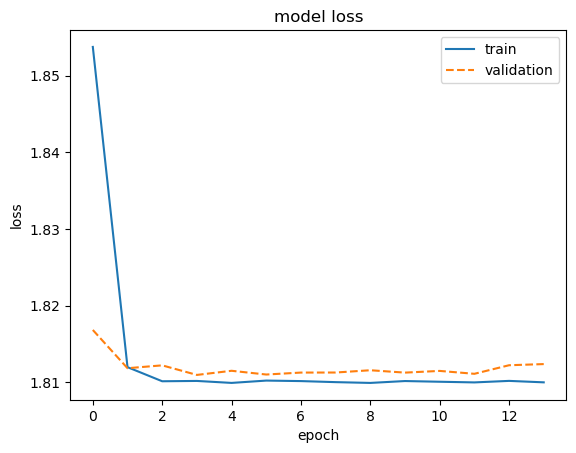

Accuracy on test set: 0.244915
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 batch_normalization_28 (Bat  (None, 48, 48, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 dropout_28 (Dropout)        (None, 24, 24, 32)        0         
                                                                 
 flatten_16 (Flatten)        (None, 18432)             0         
                                                                 
 dense_32 (Dense)     

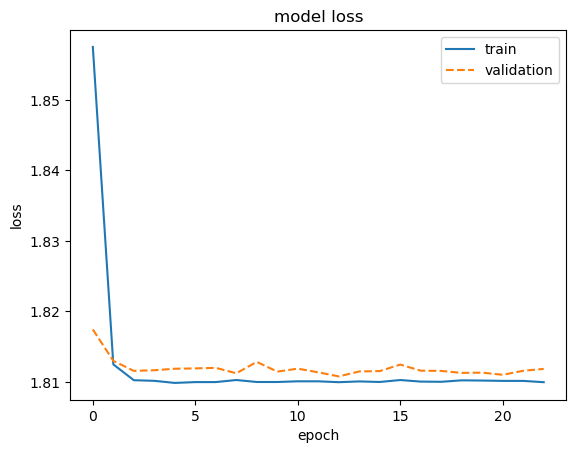

Accuracy on test set: 0.244915


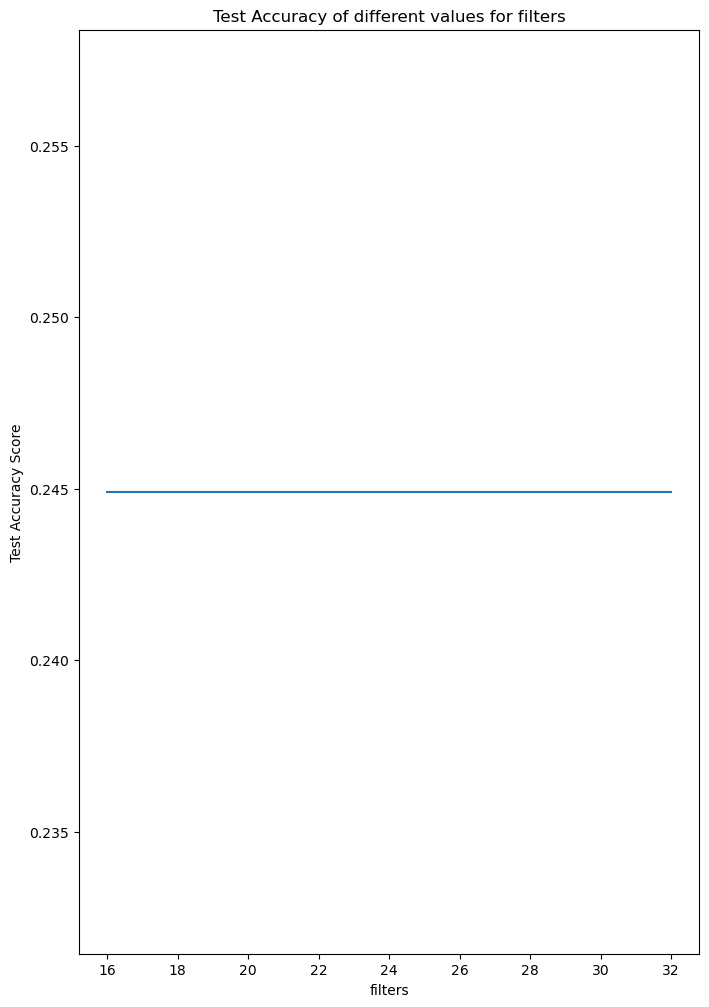

In [68]:
# running the optimization routines
# the "params" list can be modified to test different parameter specificiations.

params=[{'learning_rate': 0.005, 'epochs': 50,
        'num_convBlocks': 1, 'filters': [16]*1, 'kernel_sizes': [3]*1, 'strides': [(1,1)]*1, 'pool_sizes': [(2,2)]*1,
        'dense_units': 8, 'dropout': 0},
        {'learning_rate': 0.005, 'epochs': 50,
        'num_convBlocks': 1, 'filters': [32]*1, 'kernel_sizes': [3]*1, 'strides': [(1,1)]*1, 'pool_sizes': [(2,2)]*1,
        'dense_units': 8, 'dropout': 0}
        ]

results_dict = plot_accuracy_for_parameter(param_name='filters', values=[16, 32], parameter_dicts=params)

In [19]:
print(results_dict)

{'parameter name': 'num_convBlocks', 'values': [1, 2], 'test_accuracies': [0.244915, 0.244915]}


### 5.1) Making plots for the report

['constant (16)', 'constant (16)', 'constant (16)', 'constant (16)', 'constant (16)', 'increasing', 'increasing', 'increasing', 'increasing', 'increasing']


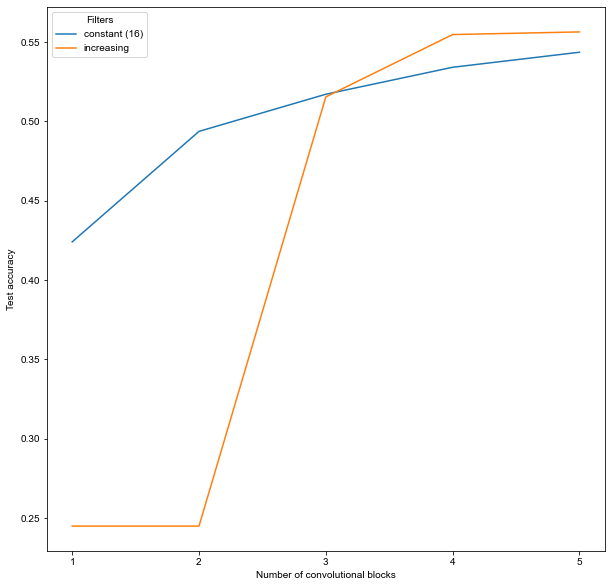

In [ ]:
# since we did not want to have 30 of the above cells just wasting space in this notebook, we wrote down the results from the individual experiments
# such that we can now put them in a data frame and plot them
# making plots from the generated accuracy scores from the experiments

num_blocks = [1,2,3,4,5]*2
filters = (['constant (16)']*5)+(['increasing']*5)
accuracies = [0.424074, 0.493731, 0.517136, 0.534132, 0.543605, 0.244915, 0.244915, 0.515464, 0.554751, 0.556422]
plot_df = pd.DataFrame({'Number of convolutional blocks': num_blocks, 'Filters': filters, 'Test accuracy': accuracies})

fig, ax = plt.subplots(figsize=(10,10))
plot = sns.lineplot(data=plot_df, x='Number of convolutional blocks', y='Test accuracy', hue='Filters')
plot.set_xticks([1,2,3,4,5])
plot.set_xlabel("Number of convolutional blocks")
plot.set_ylabel("Test accuracy")
sns.set_theme()
plt.show()

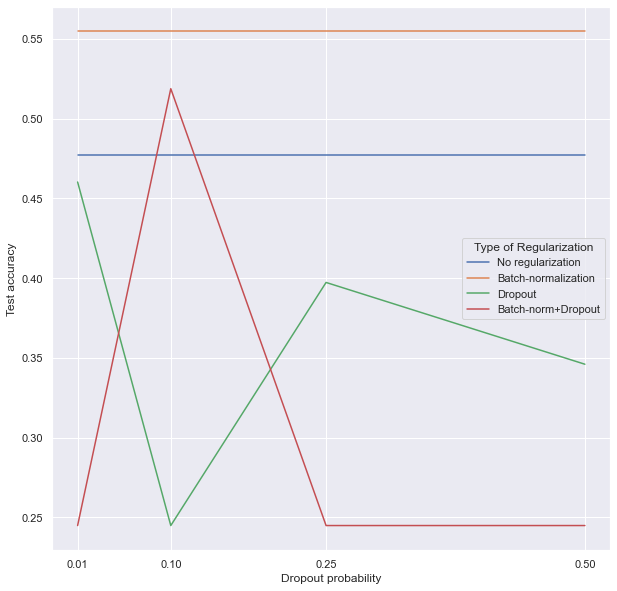

In [21]:
# making plots from the generated accuracy scores from the experiments

dropout_probability = [0.01, 0.1, 0.25, 0.5]*4
regularization = (['No regularization']*4)+(['Batch-normalization']*4)+(['Dropout']*4)+(['Batch-norm+Dropout']*4)
accuracies = ([0.477292]*4)+([0.554751]*4)+[0.460295, 0.244915, 0.397325, 0.346057, 0.244915, 0.518807, 0.244915, 0.244915]
plot_df = pd.DataFrame({'Dropout probability': dropout_probability, 'Type of Regularization': regularization, 'Test accuracy': accuracies})

fig, ax = plt.subplots(figsize=(10,10))
plot = sns.lineplot(data=plot_df, x='Dropout probability', y='Test accuracy', hue='Type of Regularization')
plot.set_xticks([0.01, 0.1, 0.25, 0.5])
plot.set_xlabel("Dropout probability")
plot.set_ylabel("Test accuracy")
sns.set_theme()
plt.show()

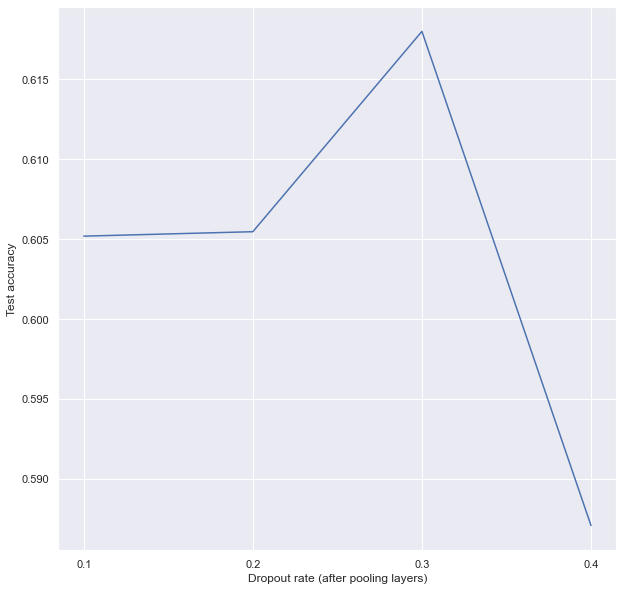

In [22]:
fig, ax = plt.subplots(figsize=(10,10))
plot = sns.lineplot(x=[0.1, 0.2, 0.3, 0.4], y=[0.605183, 0.605461, 0.617999, 0.587072])
plot.set_xticks([0.1, 0.2, 0.3, 0.4])
plot.set_xlabel("Dropout rate (after pooling layers)")
plot.set_ylabel("Test accuracy")
sns.set_theme()
plt.show()

## 6) Training the final model with optimized parameters

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 48, 48, 16)        160       
                                                                 
 batch_normalization_20 (Bat  (None, 48, 48, 16)       64        
 chNormalization)                                                
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 24, 24, 16)       0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 24, 24, 16)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 12, 12, 32)     

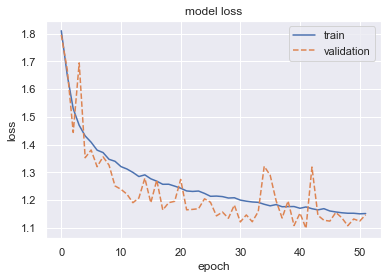

Accuracy on test set: 0.600724


In [25]:
best_parameters = {'learning_rate': 0.005, 'epochs':100,
            'num_convBlocks': 5, 'filters': [16, 32, 64, 128, 256], 'kernel_sizes': [3]*5, 'strides': [(1,1)]*5, 'pool_sizes': [(2,2)]*5,
            'dense_units': 8, 'dropout': 0}
best_model, best_history = train_model(**best_parameters)

In [ ]:
# loading/saving the model to not need to do re-training (if available)
# best_model.save("my_h5_model.h5")
# best_model = keras.models.load_model("my_h5_model.h5")

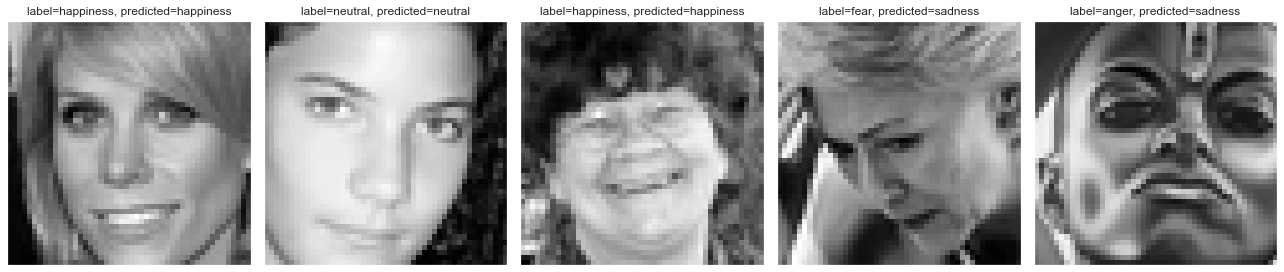

In [26]:
# printing 5 random images with their labels and predictions

emotion_dict = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

probabilites = best_model.predict(X_test, workers=12)
predictions = np.argmax(probabilites, axis=1)
random_int = np.random.randint(low=0, high=3590-5)

fig = plt.figure(figsize=(18, 5))

for i, prediction in enumerate(predictions[random_int:random_int+5]):
    ax = plt.subplot(1, 5, i+1)
    ax.imshow(X_test[random_int+i], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'label={emotion_dict[df_test.emotion.iloc[random_int+i]]}, predicted={emotion_dict[prediction]}')
plt.tight_layout()

### 6.1) Evaluating the model

Scores of the final model
Test accuracy: 0.600724
     emotion  precision    recall
0      anger   0.633846  0.419552
1    disgust   0.739130  0.309091
2       fear   0.412533  0.299242
3  happiness   0.796375  0.849829
4    sadness   0.460000  0.503367
5   surprise   0.684783  0.757212
6    neutral   0.511111  0.661342


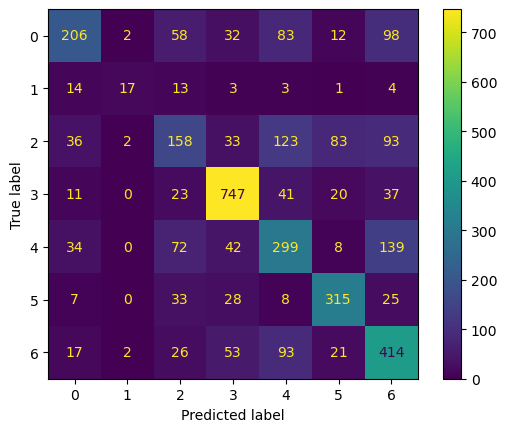

In [37]:
# obtaining performance metrics

labels_test = np.argmax(y_test, axis=1)
best_test_accuracy = np.round(accuracy_score(y_true=labels_test, y_pred=predictions), 6)
best_test_precision = precision_score(labels_test, predictions, average=None)
best_test_recall = recall_score(labels_test, predictions, average=None)

df_prec_recall = pd.DataFrame({'emotion': ['anger','disgust','fear','happiness','sadness','surprise','neutral'],
                                'precision': best_test_precision, 'recall': best_test_recall})

print('Scores of the final model')
print(f'Test accuracy: {best_test_accuracy}')
print(df_prec_recall)

matplot.rc_file_defaults()
conf_matrix = confusion_matrix(labels_test, predictions)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot();

### 6.2) Visualizing the feature maps

label =  neutral


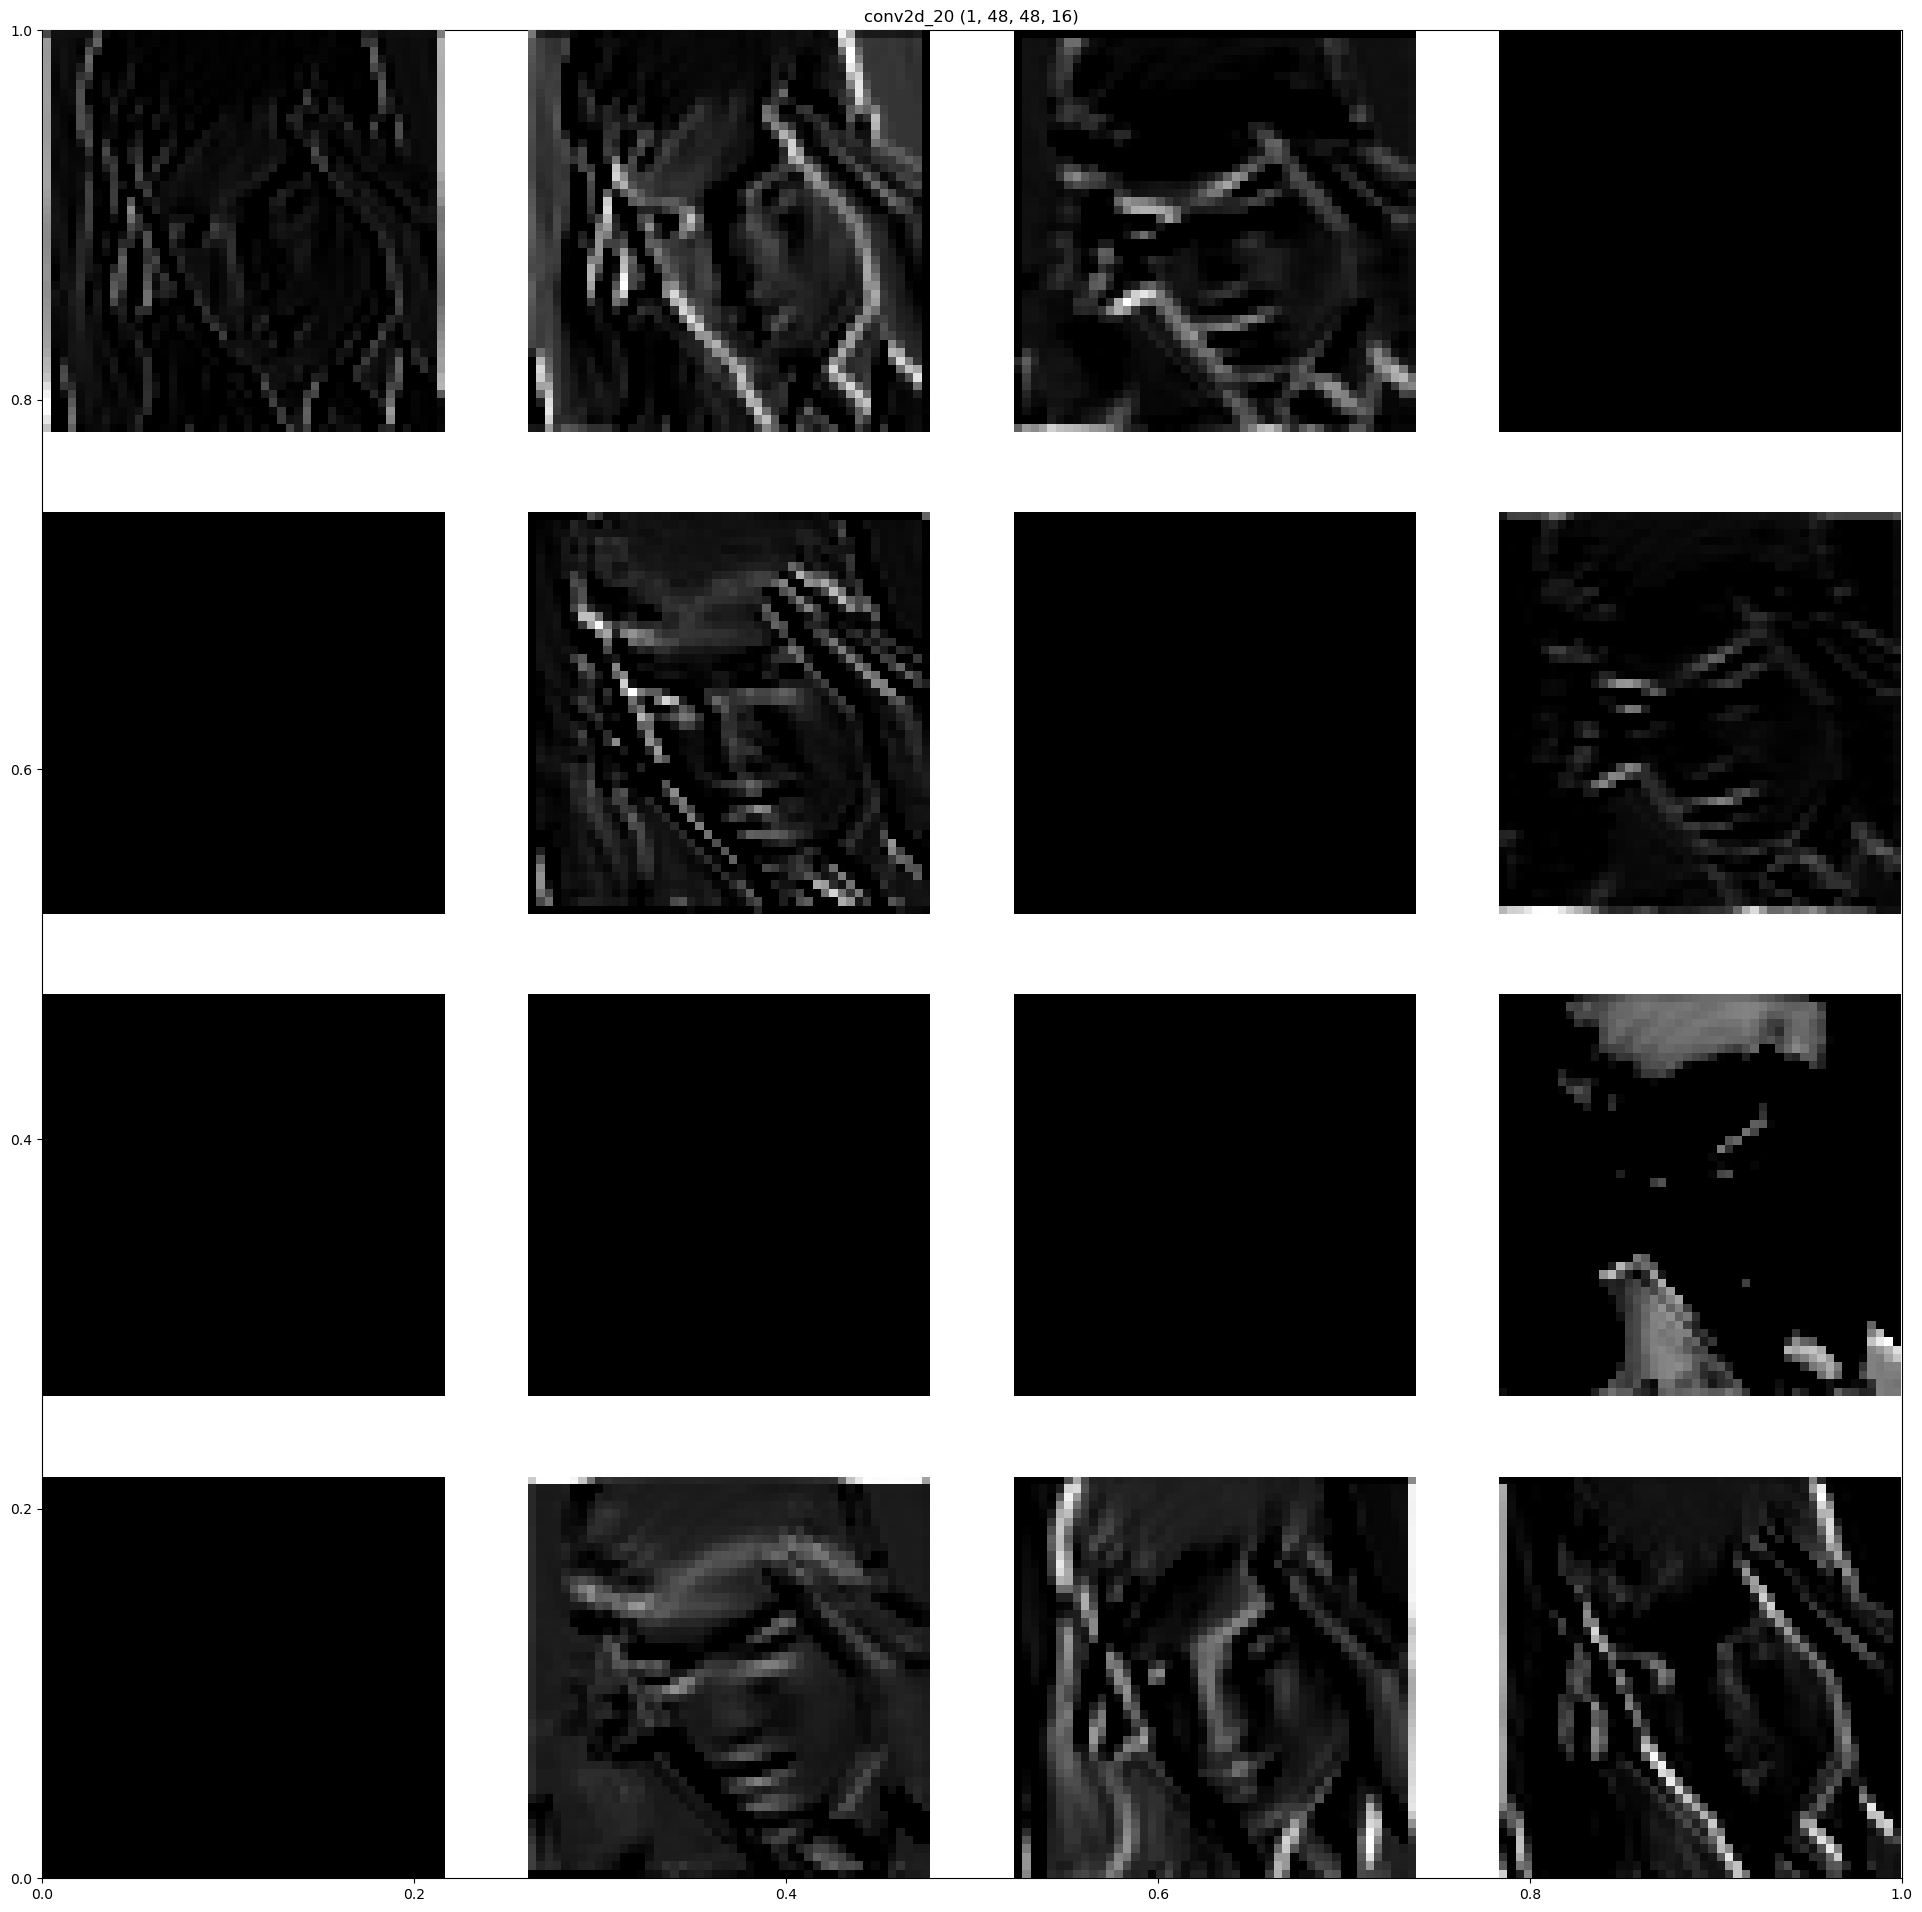

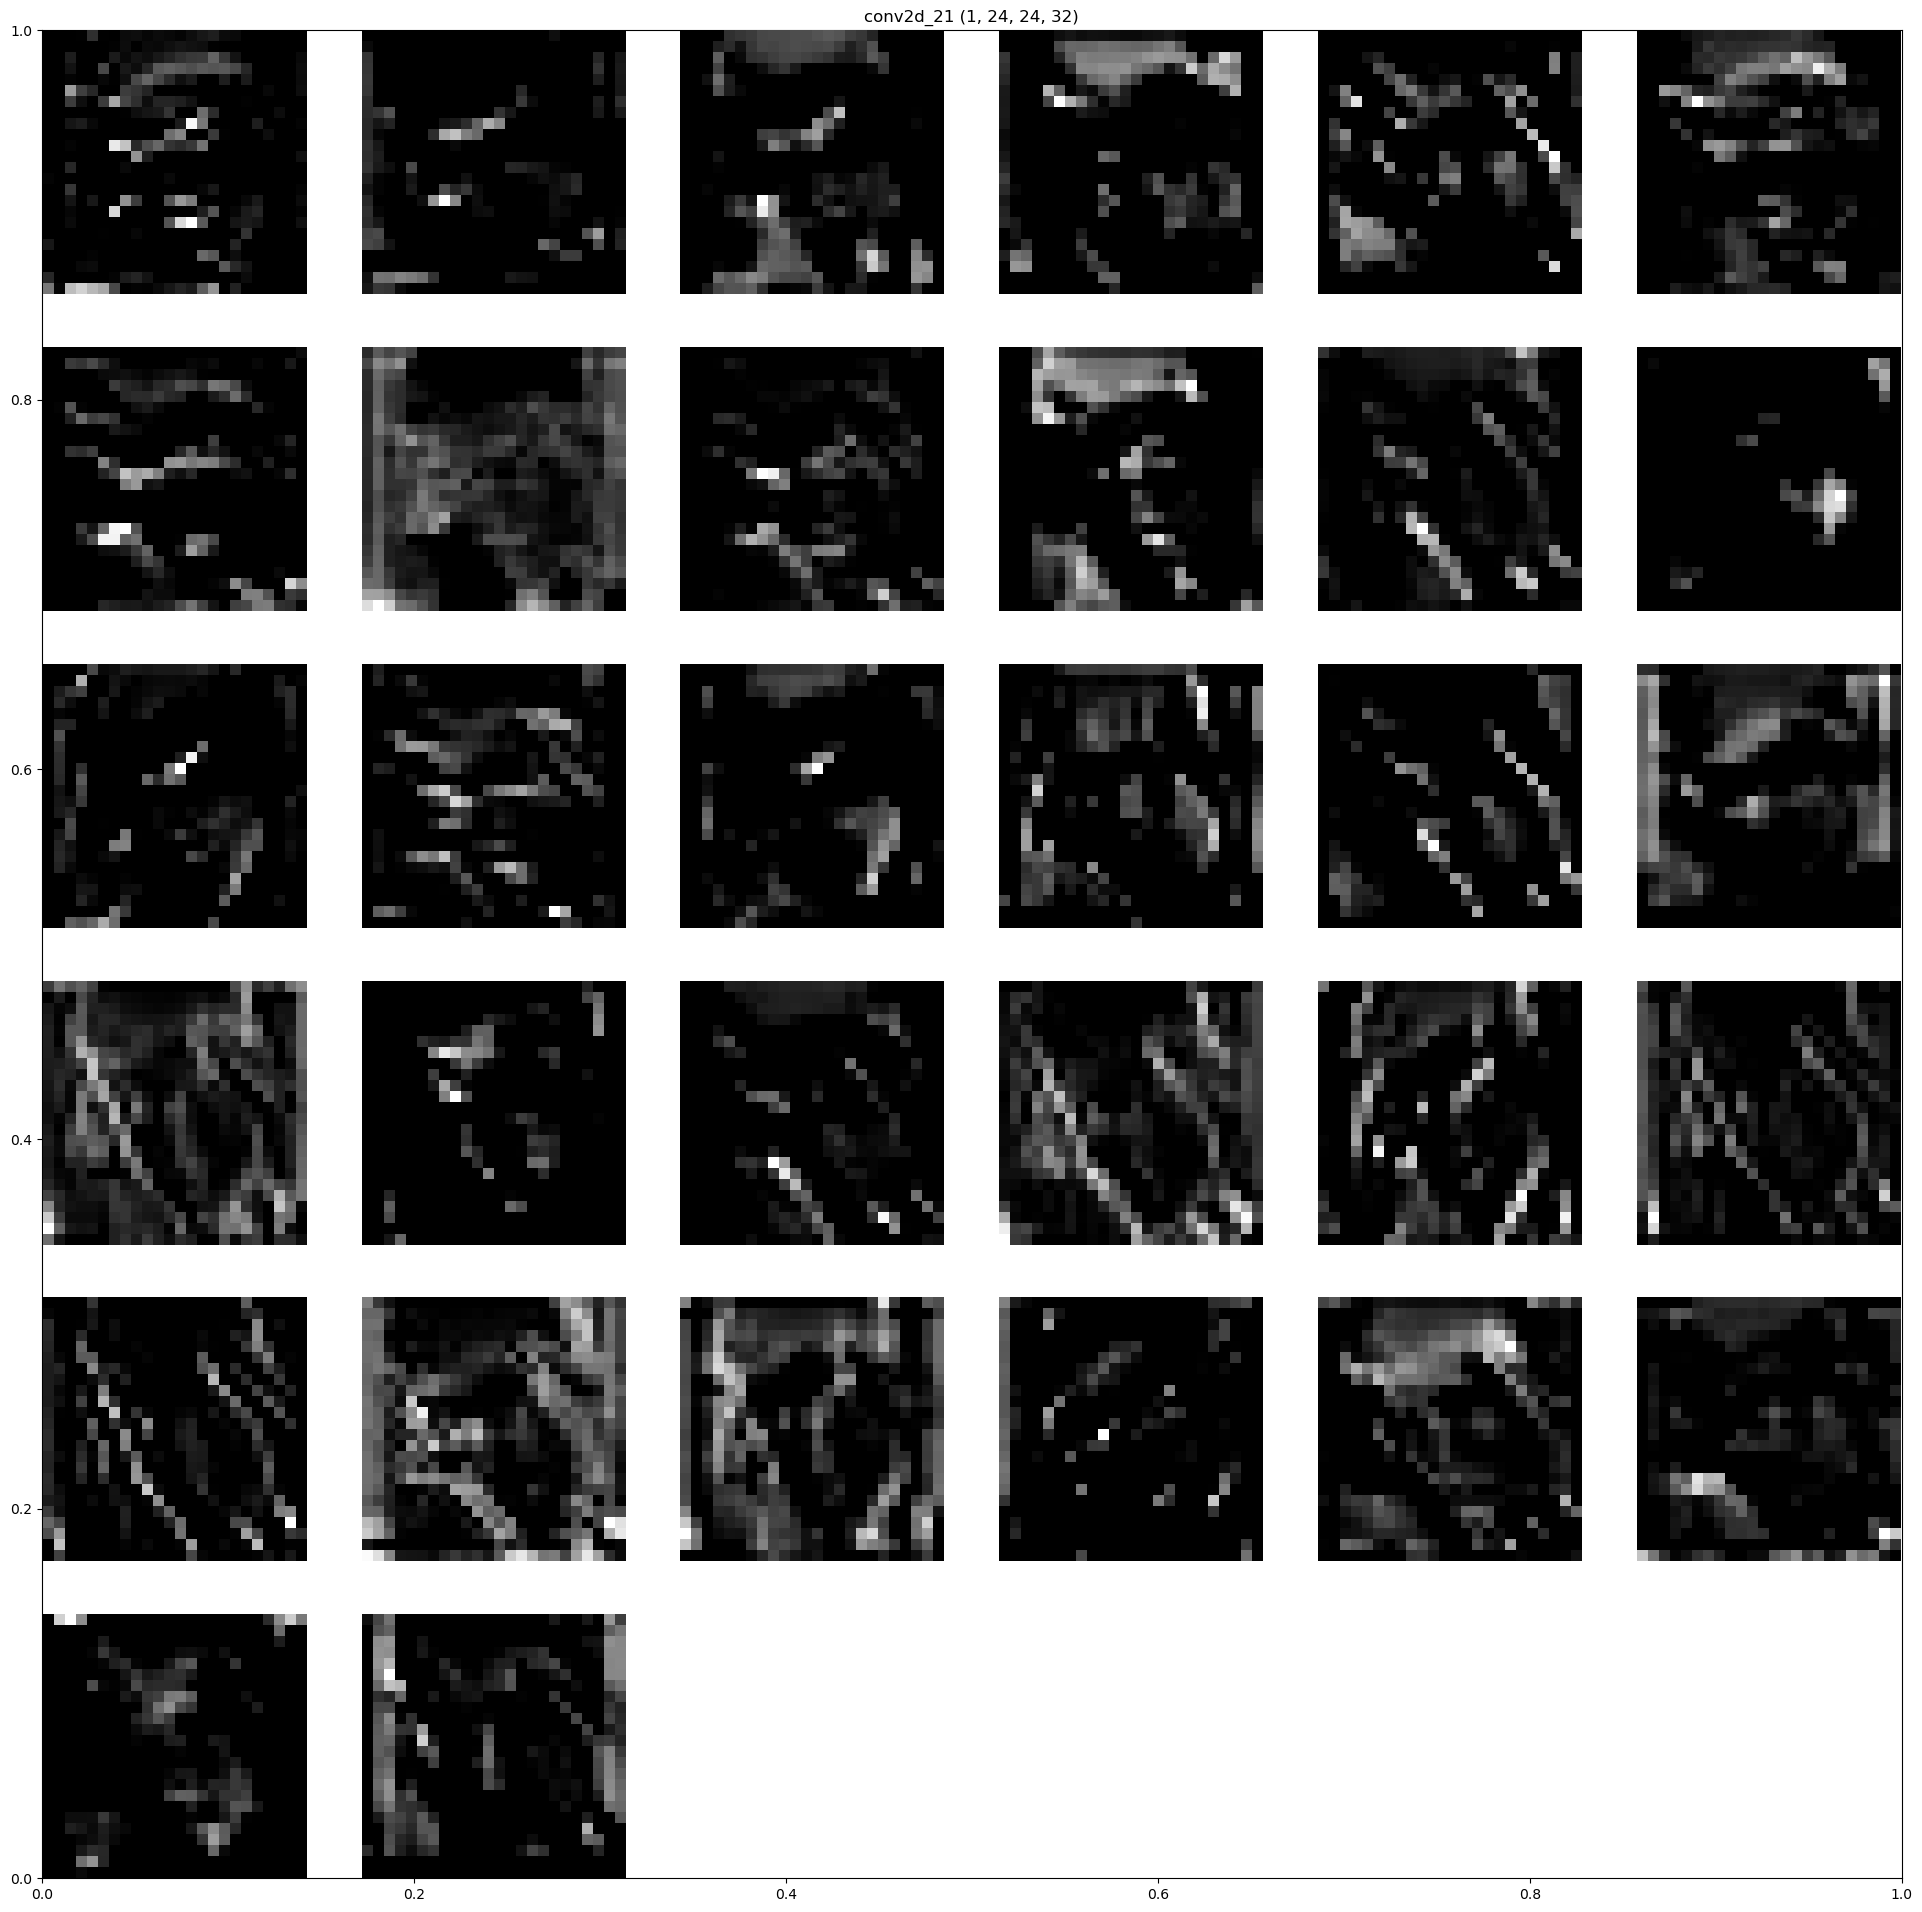

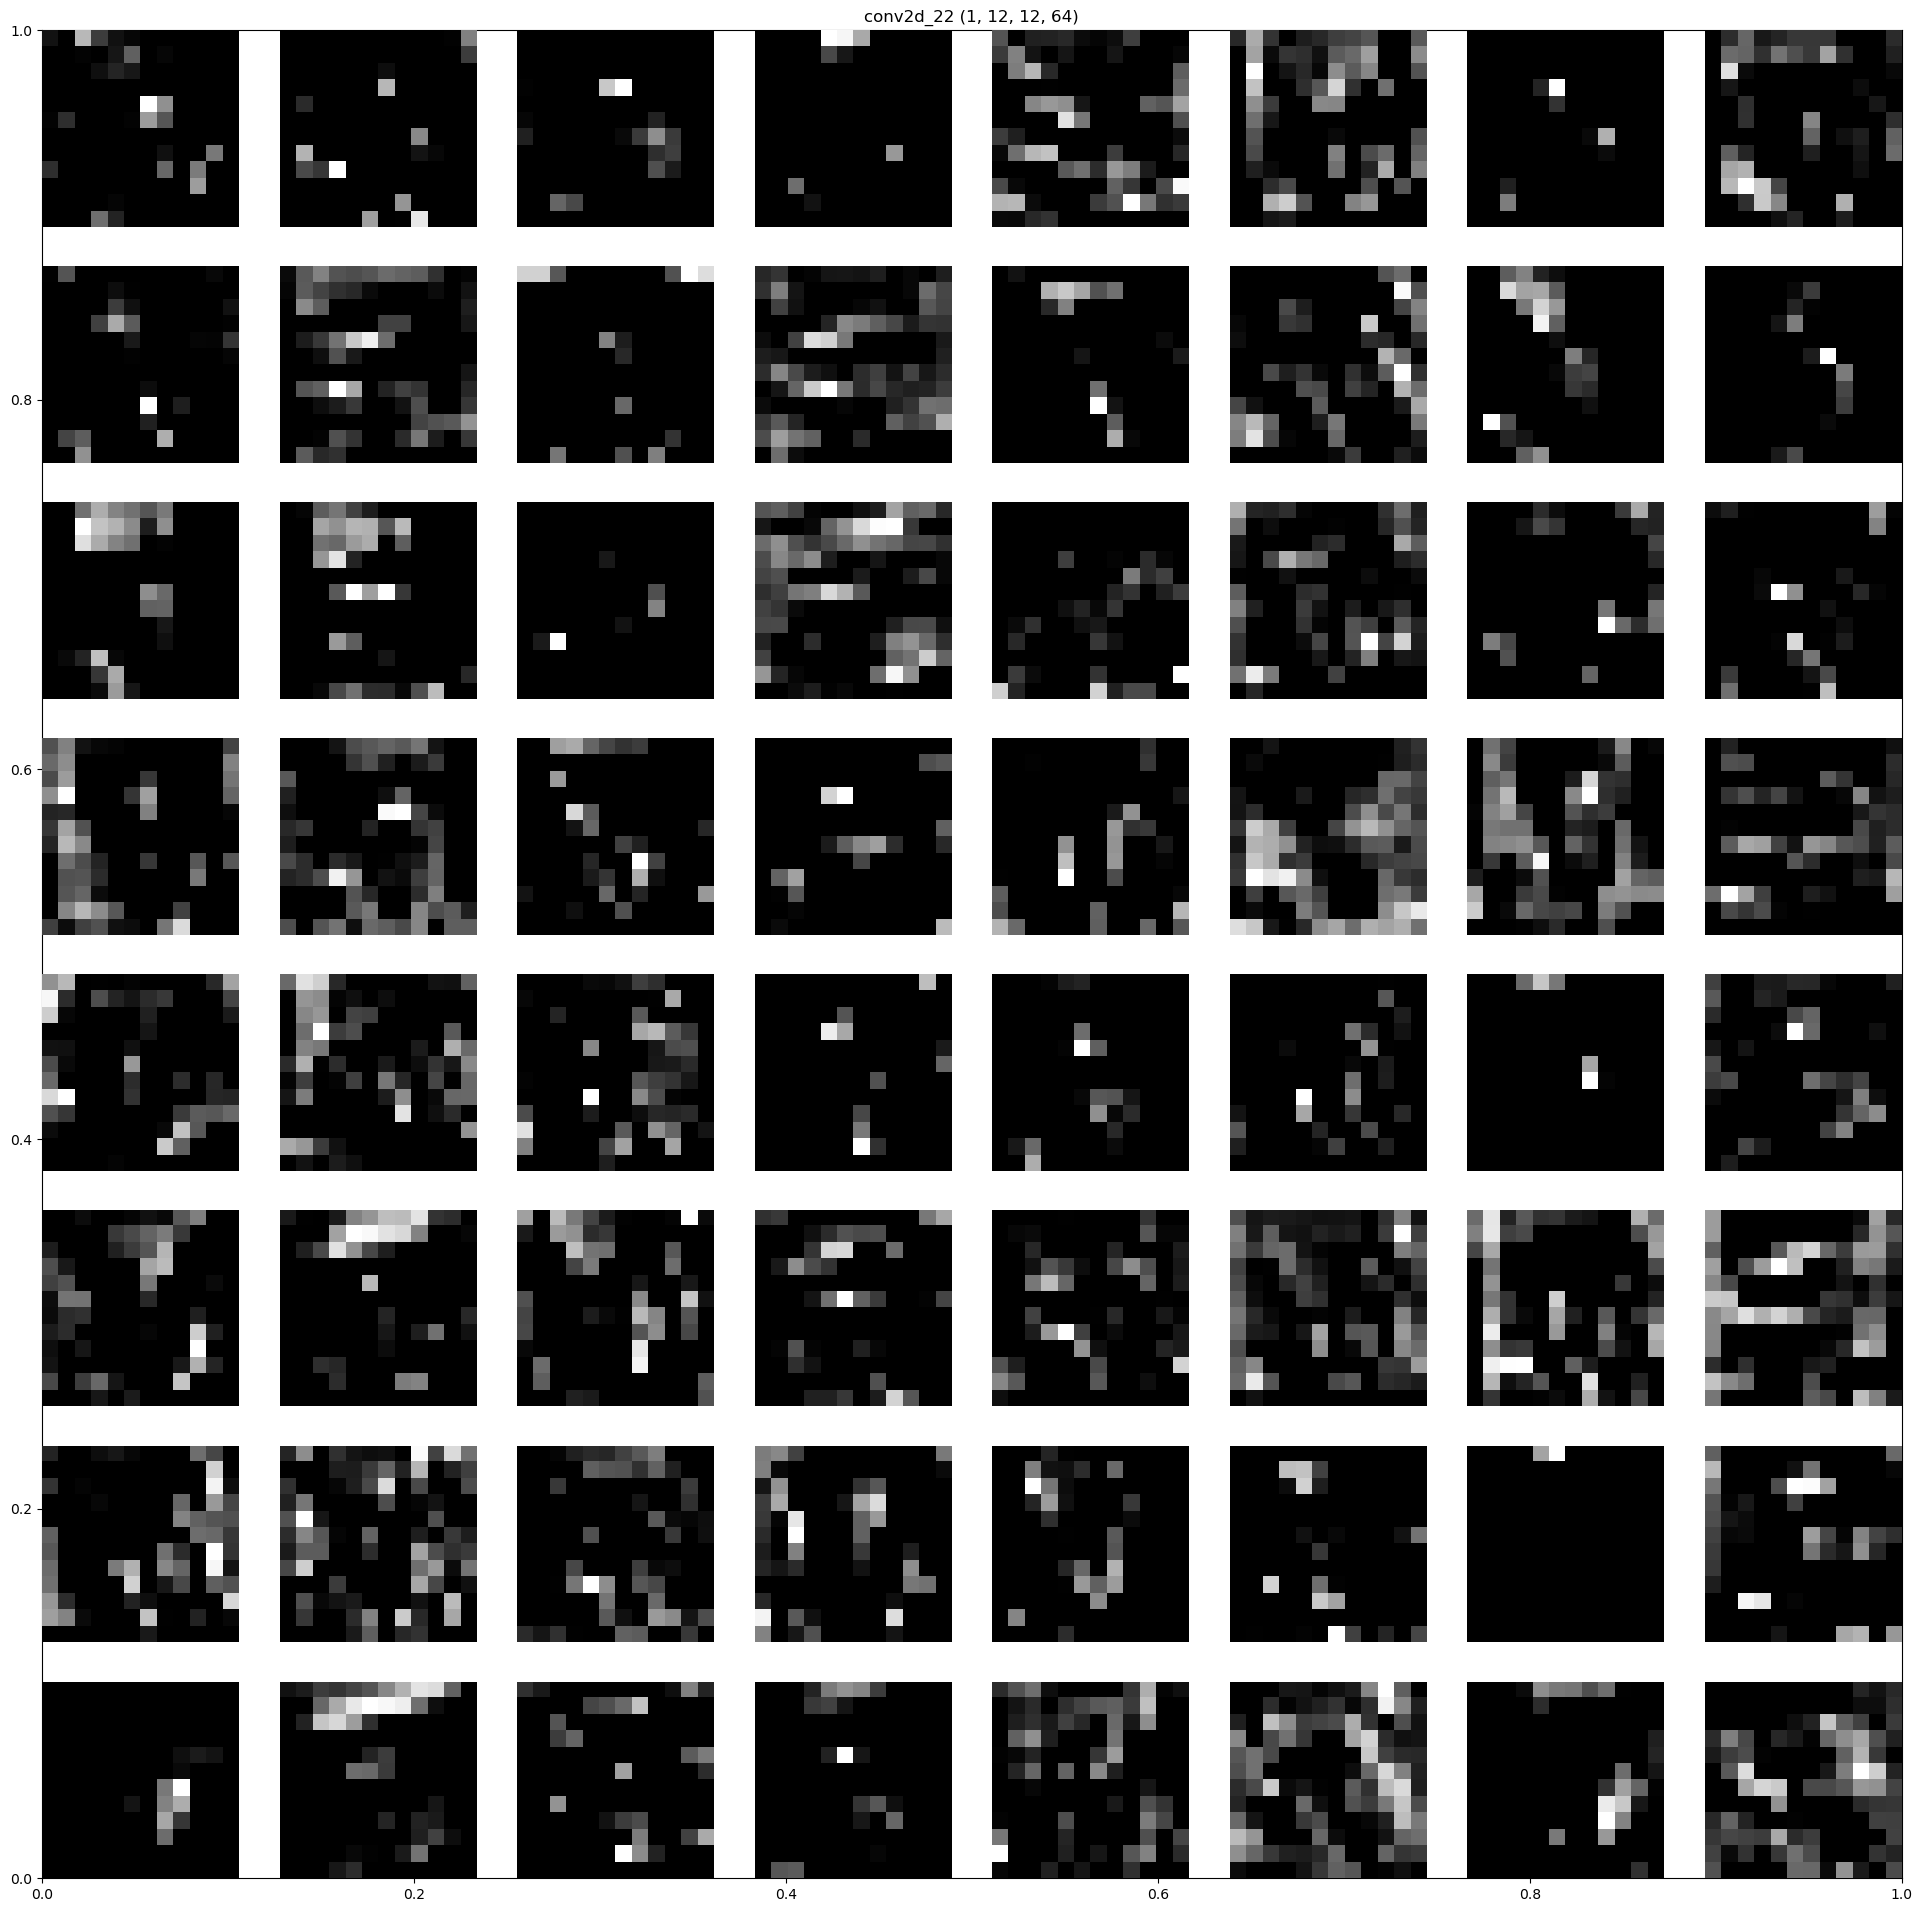

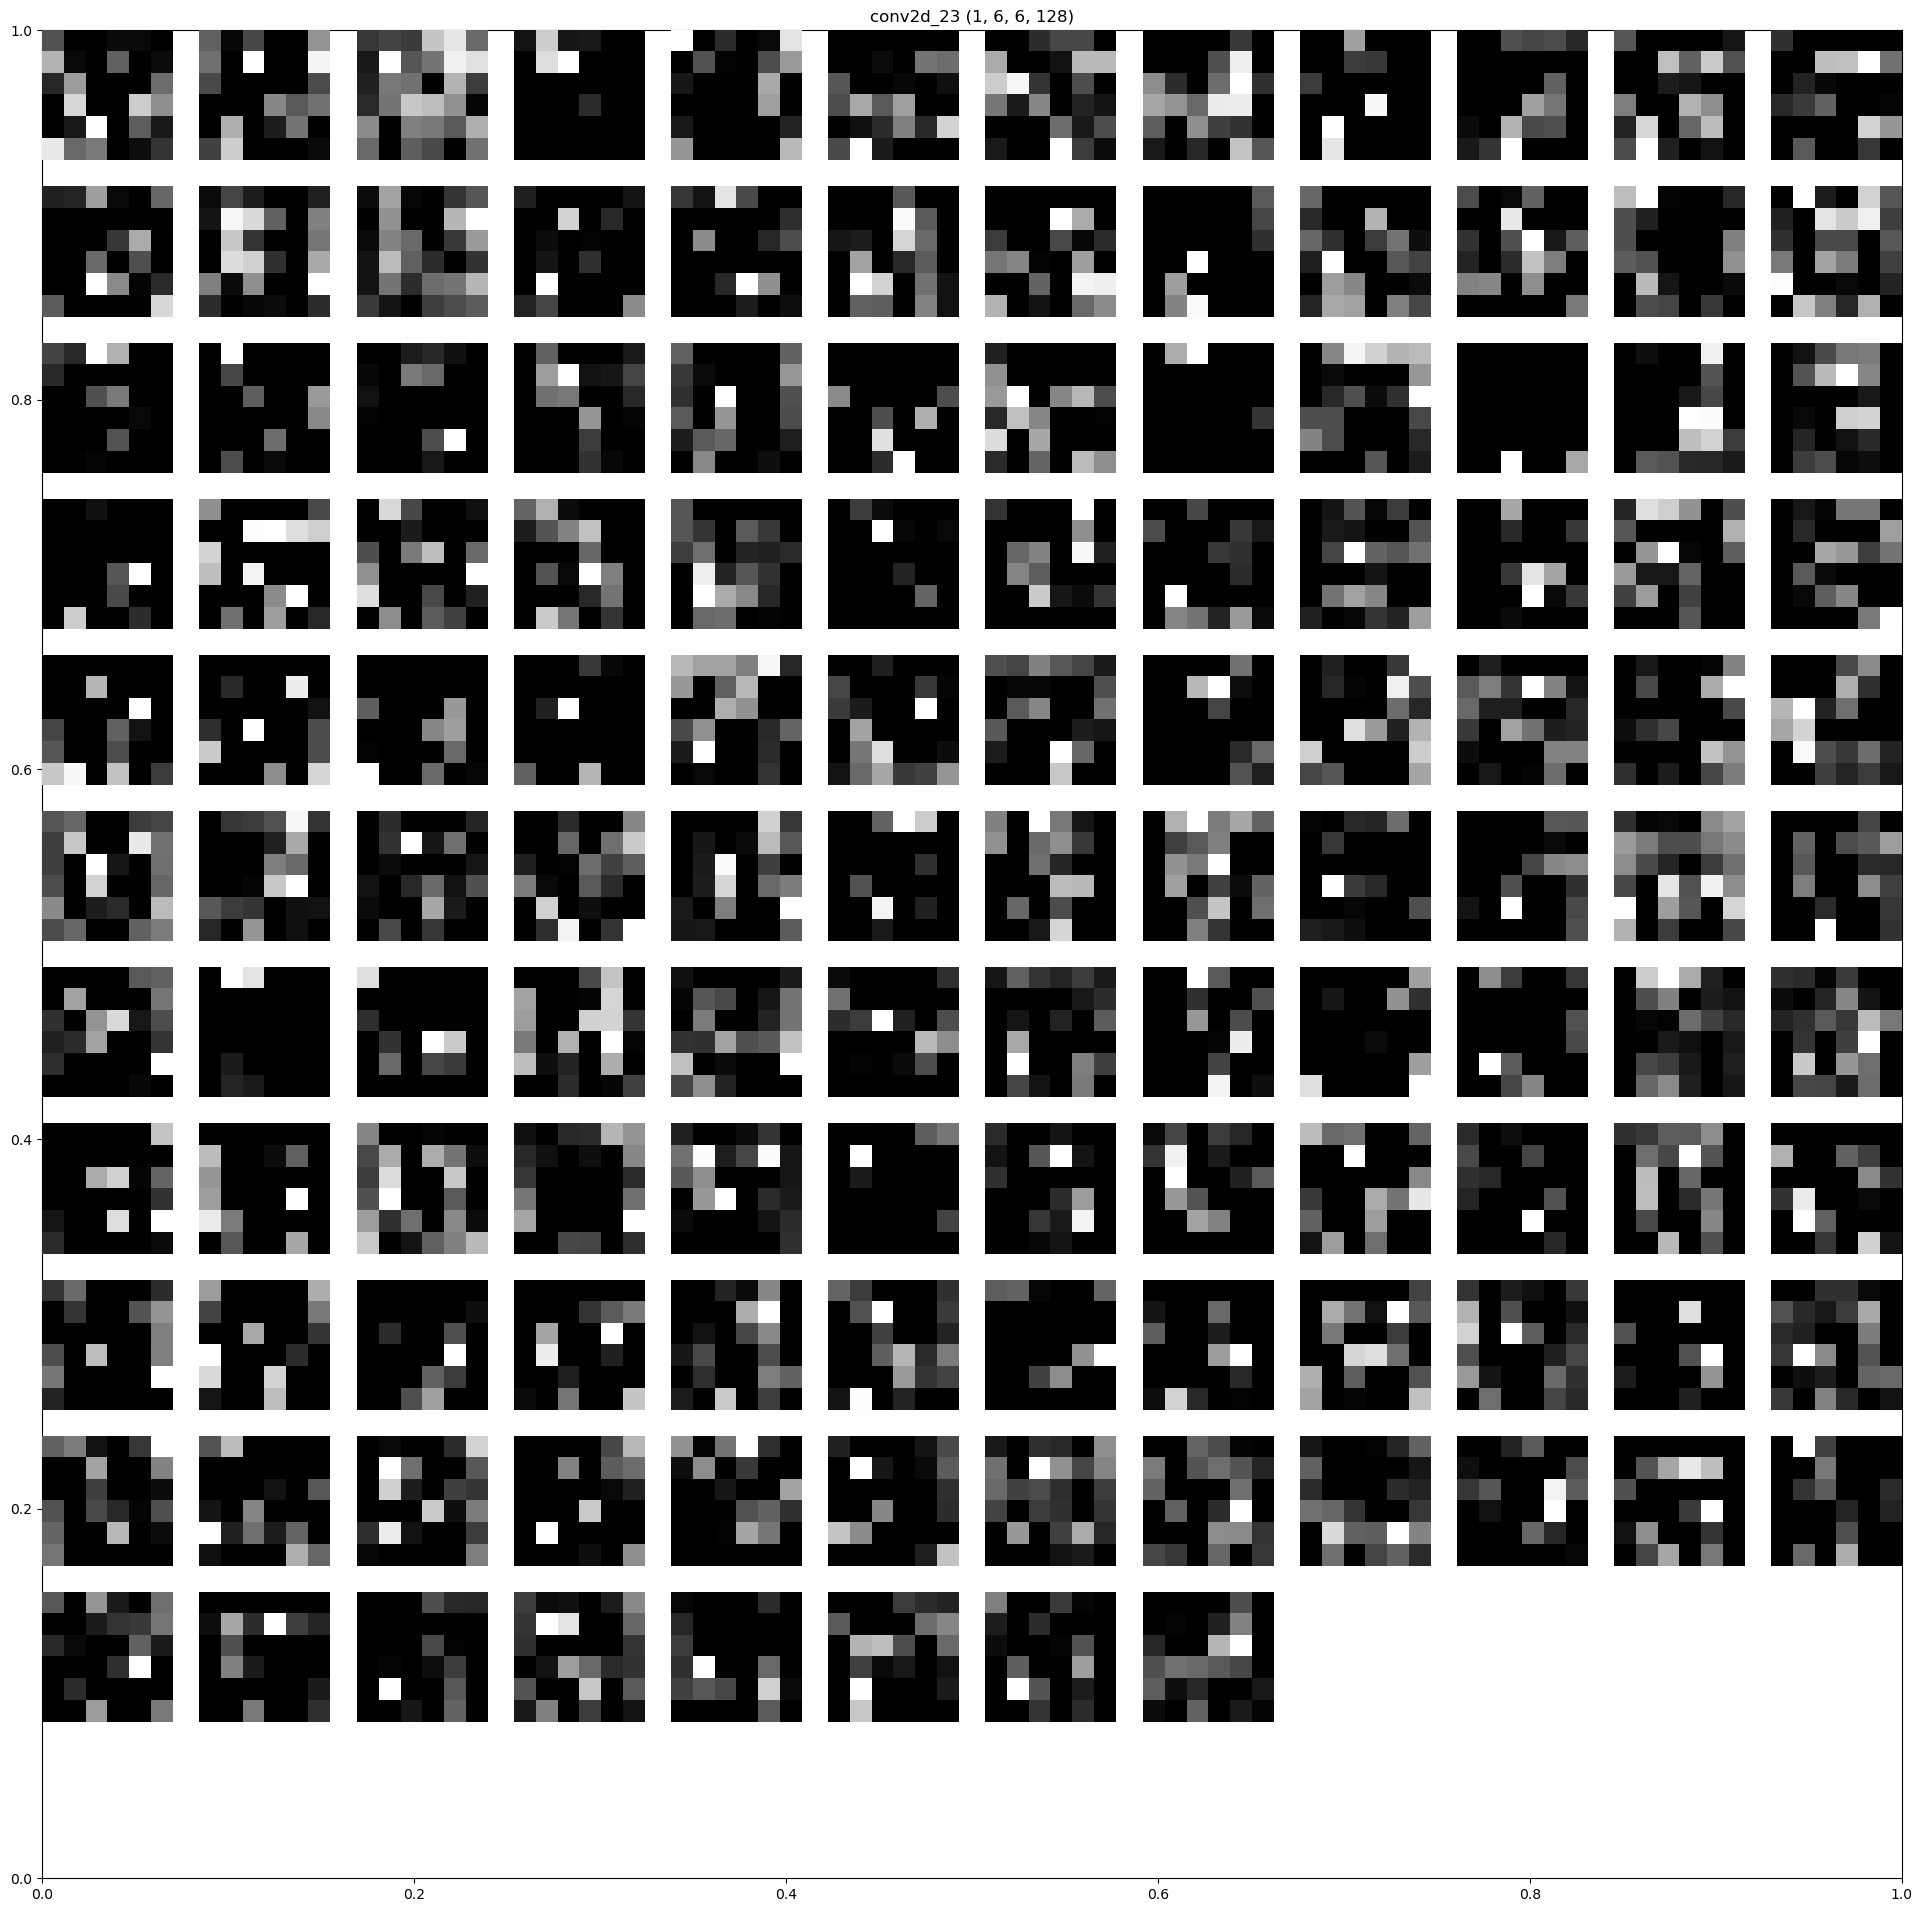

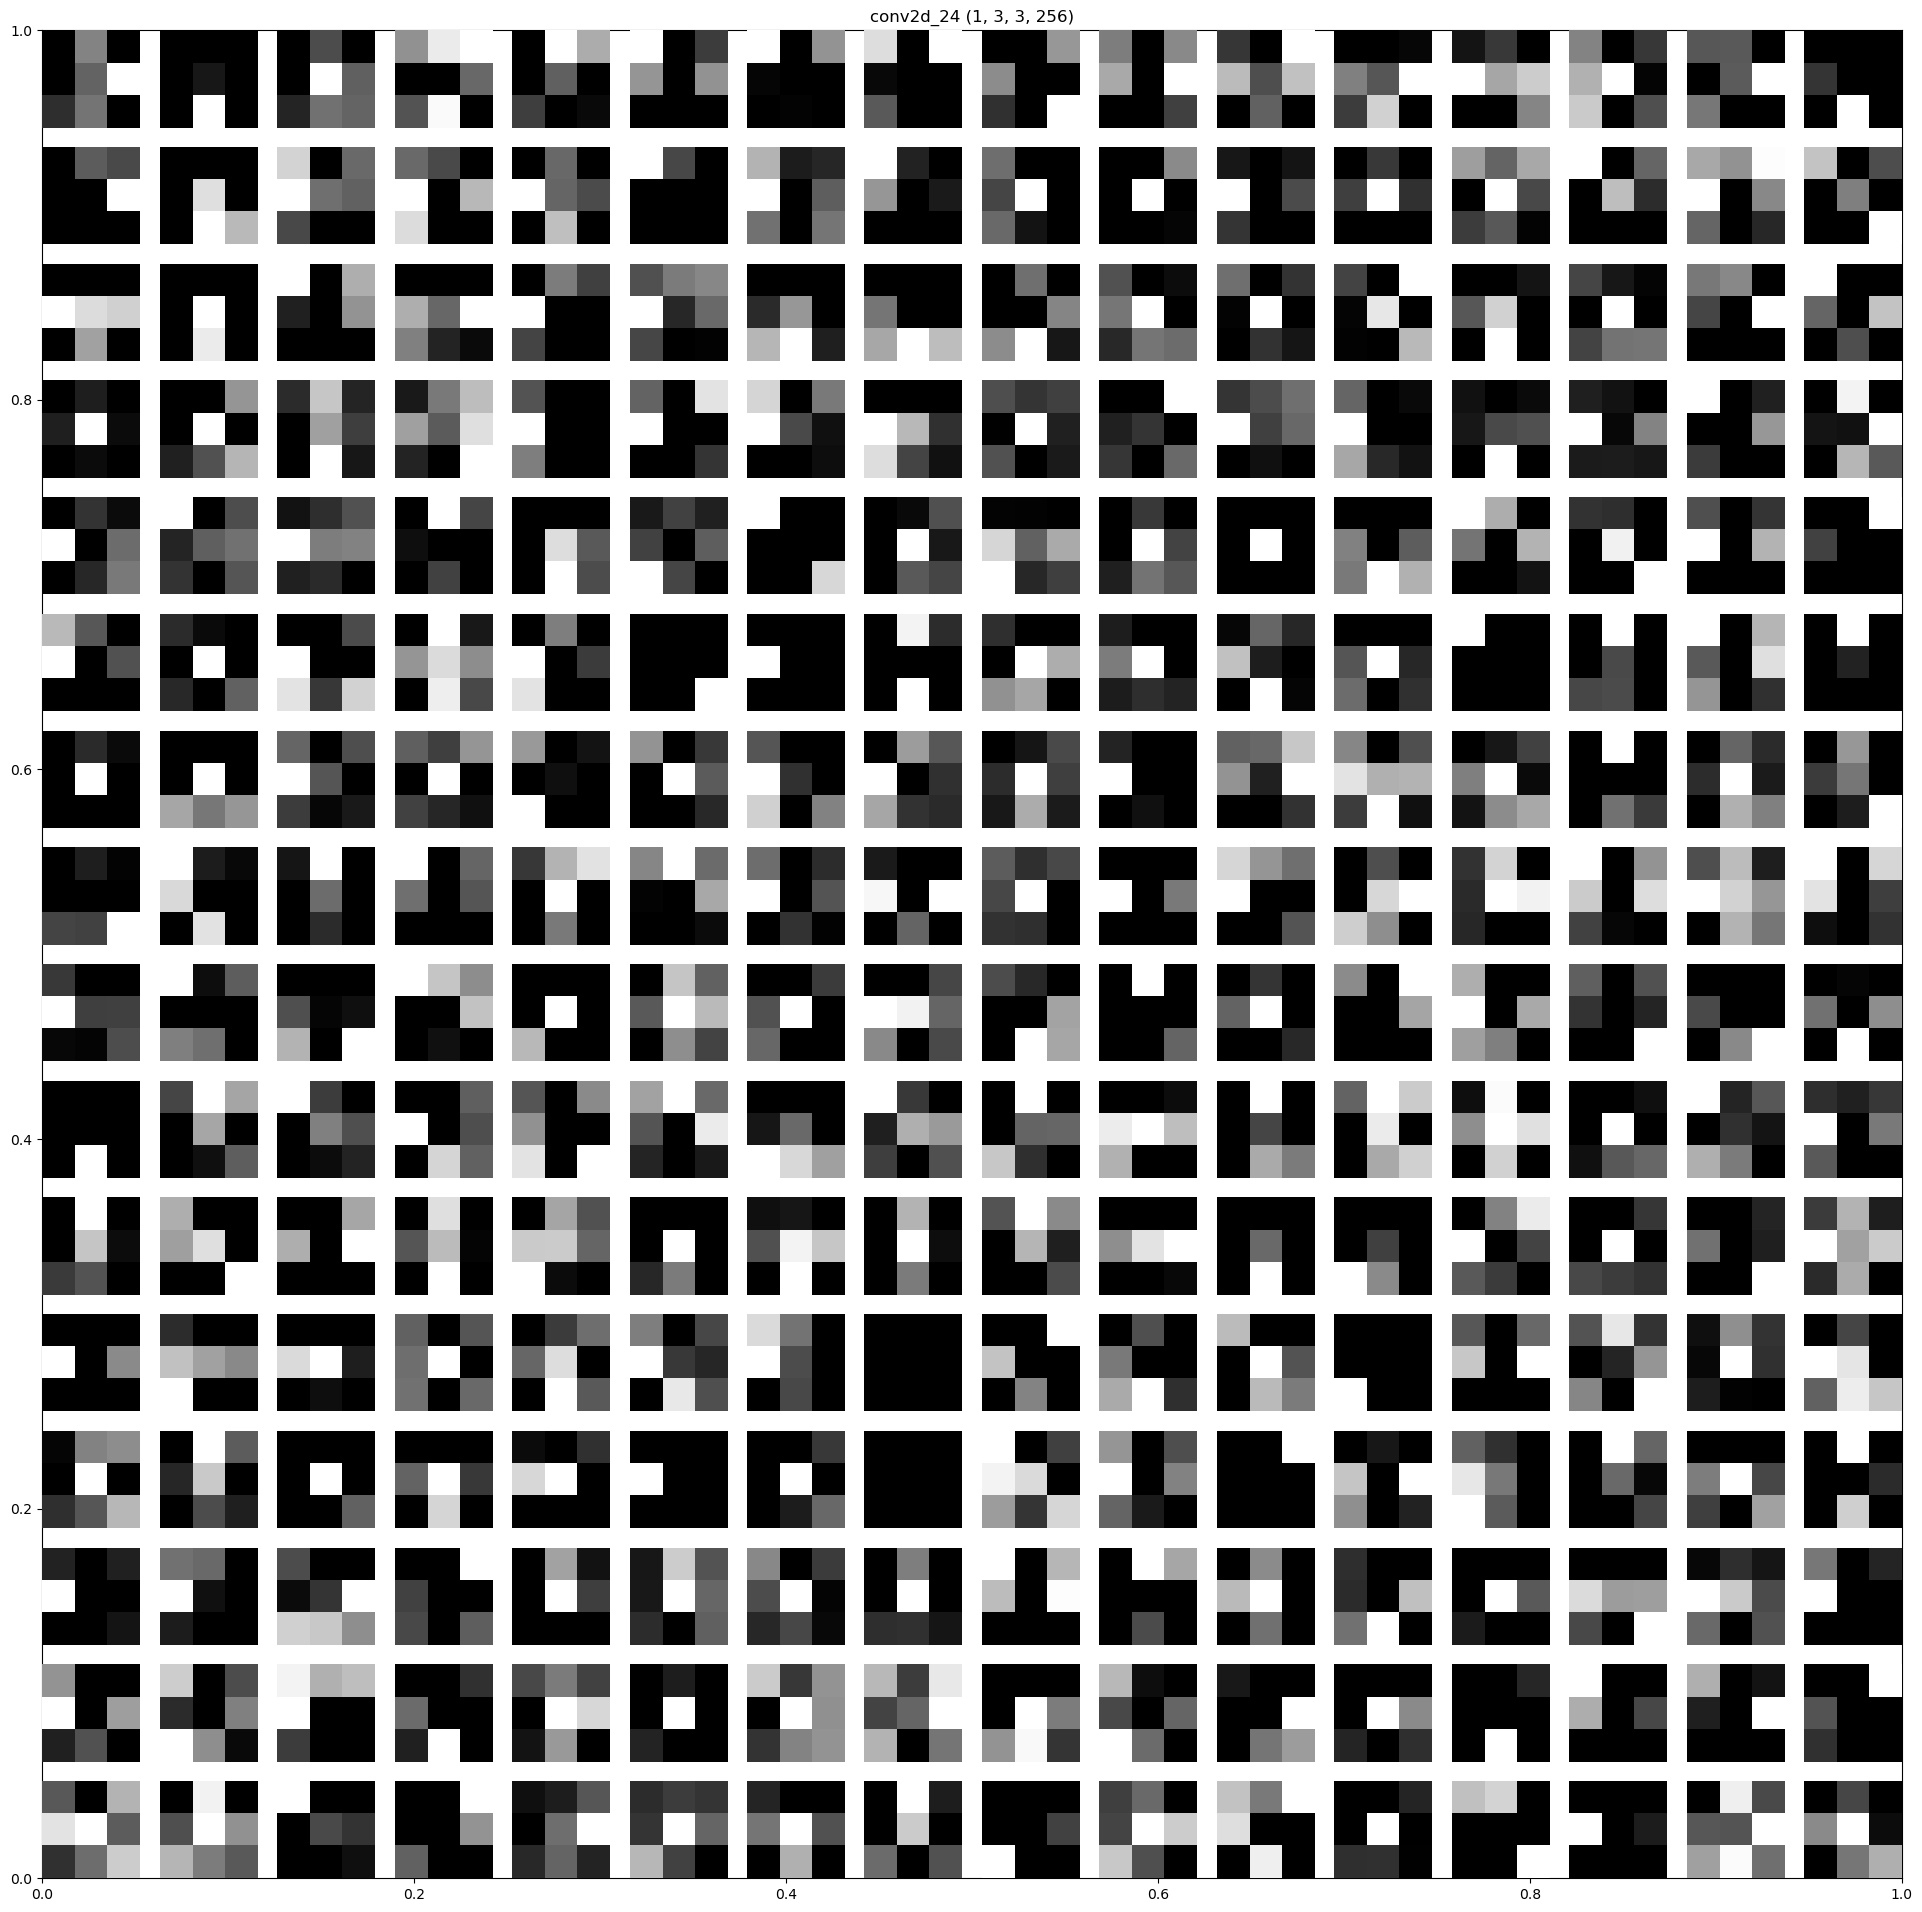

In [47]:
# getting the activations of layers for a given image (so that we can test and compare for the different classes)
def plot_filters(model, img):
    for layer in model.layers: 
        if 'conv' in layer.name:
            modelLayer = keras.models.Model(inputs=model.inputs, outputs=model.get_layer(layer.name).output).predict(img) # get the activations of the 'outputs' layer
            if(len(modelLayer.shape)>2): # do not print the last prediction layer (not a convolution layer)
                fig = plt.figure(figsize=(24,24))
                plt.title(str(layer.name+" "+str(modelLayer.shape)))
                size = int(np.ceil(np.sqrt(modelLayer.shape[3])))
                for filter in range(modelLayer.shape[3]):
                    fig.add_subplot(size,size,filter+1)
                    plt.imshow(modelLayer[0,:,:,filter], cmap='gray')
                    plt.axis('off')
print("label = ",emotion_dict[np.argmax(y_test[2])])      
plot_filters(best_model, np.expand_dims(X_test[2],axis=0))

### 6.3) Visualizing filters

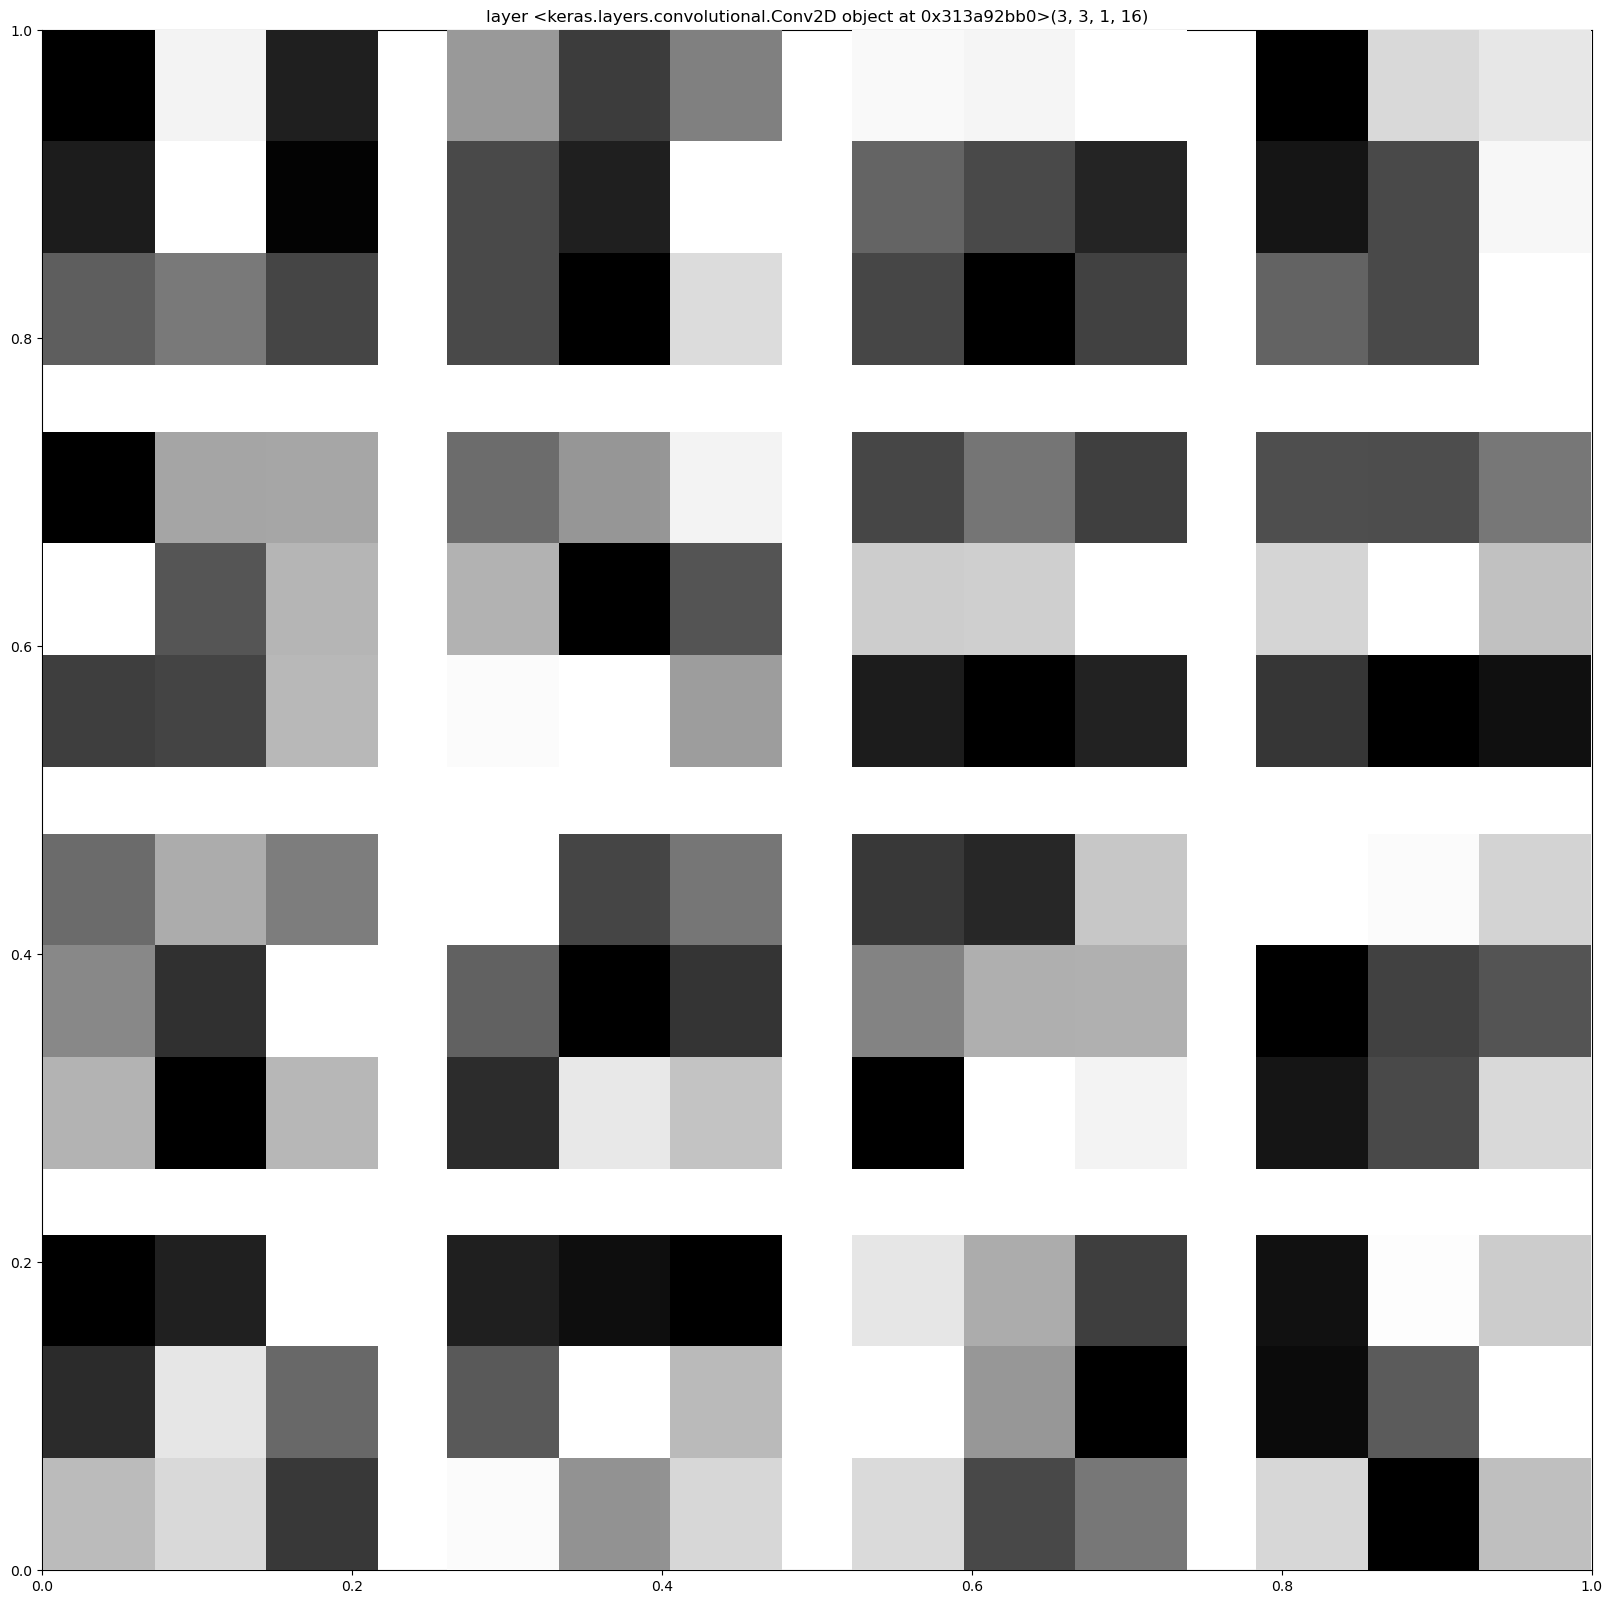

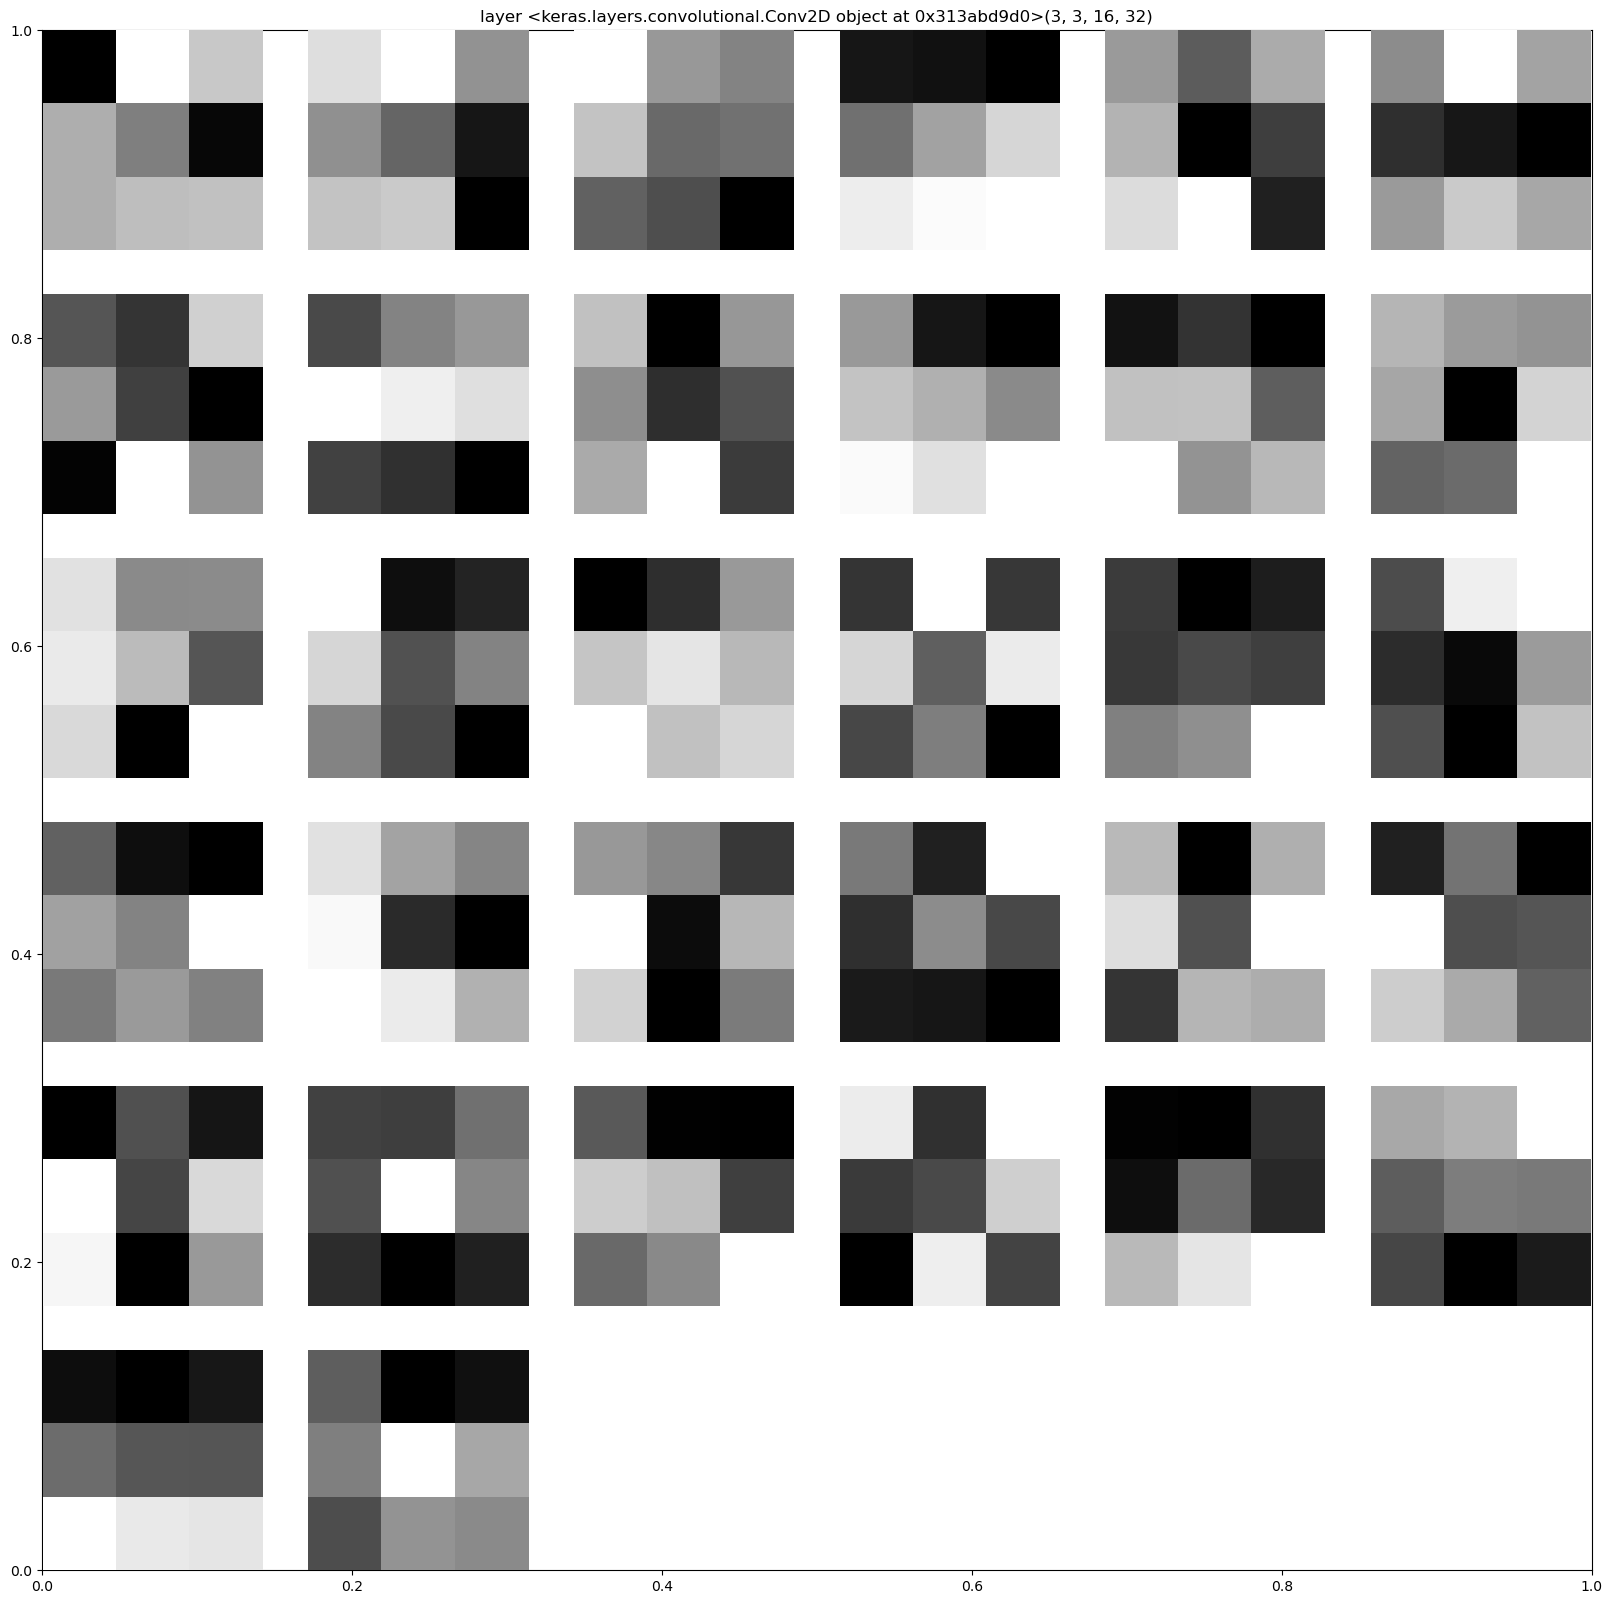

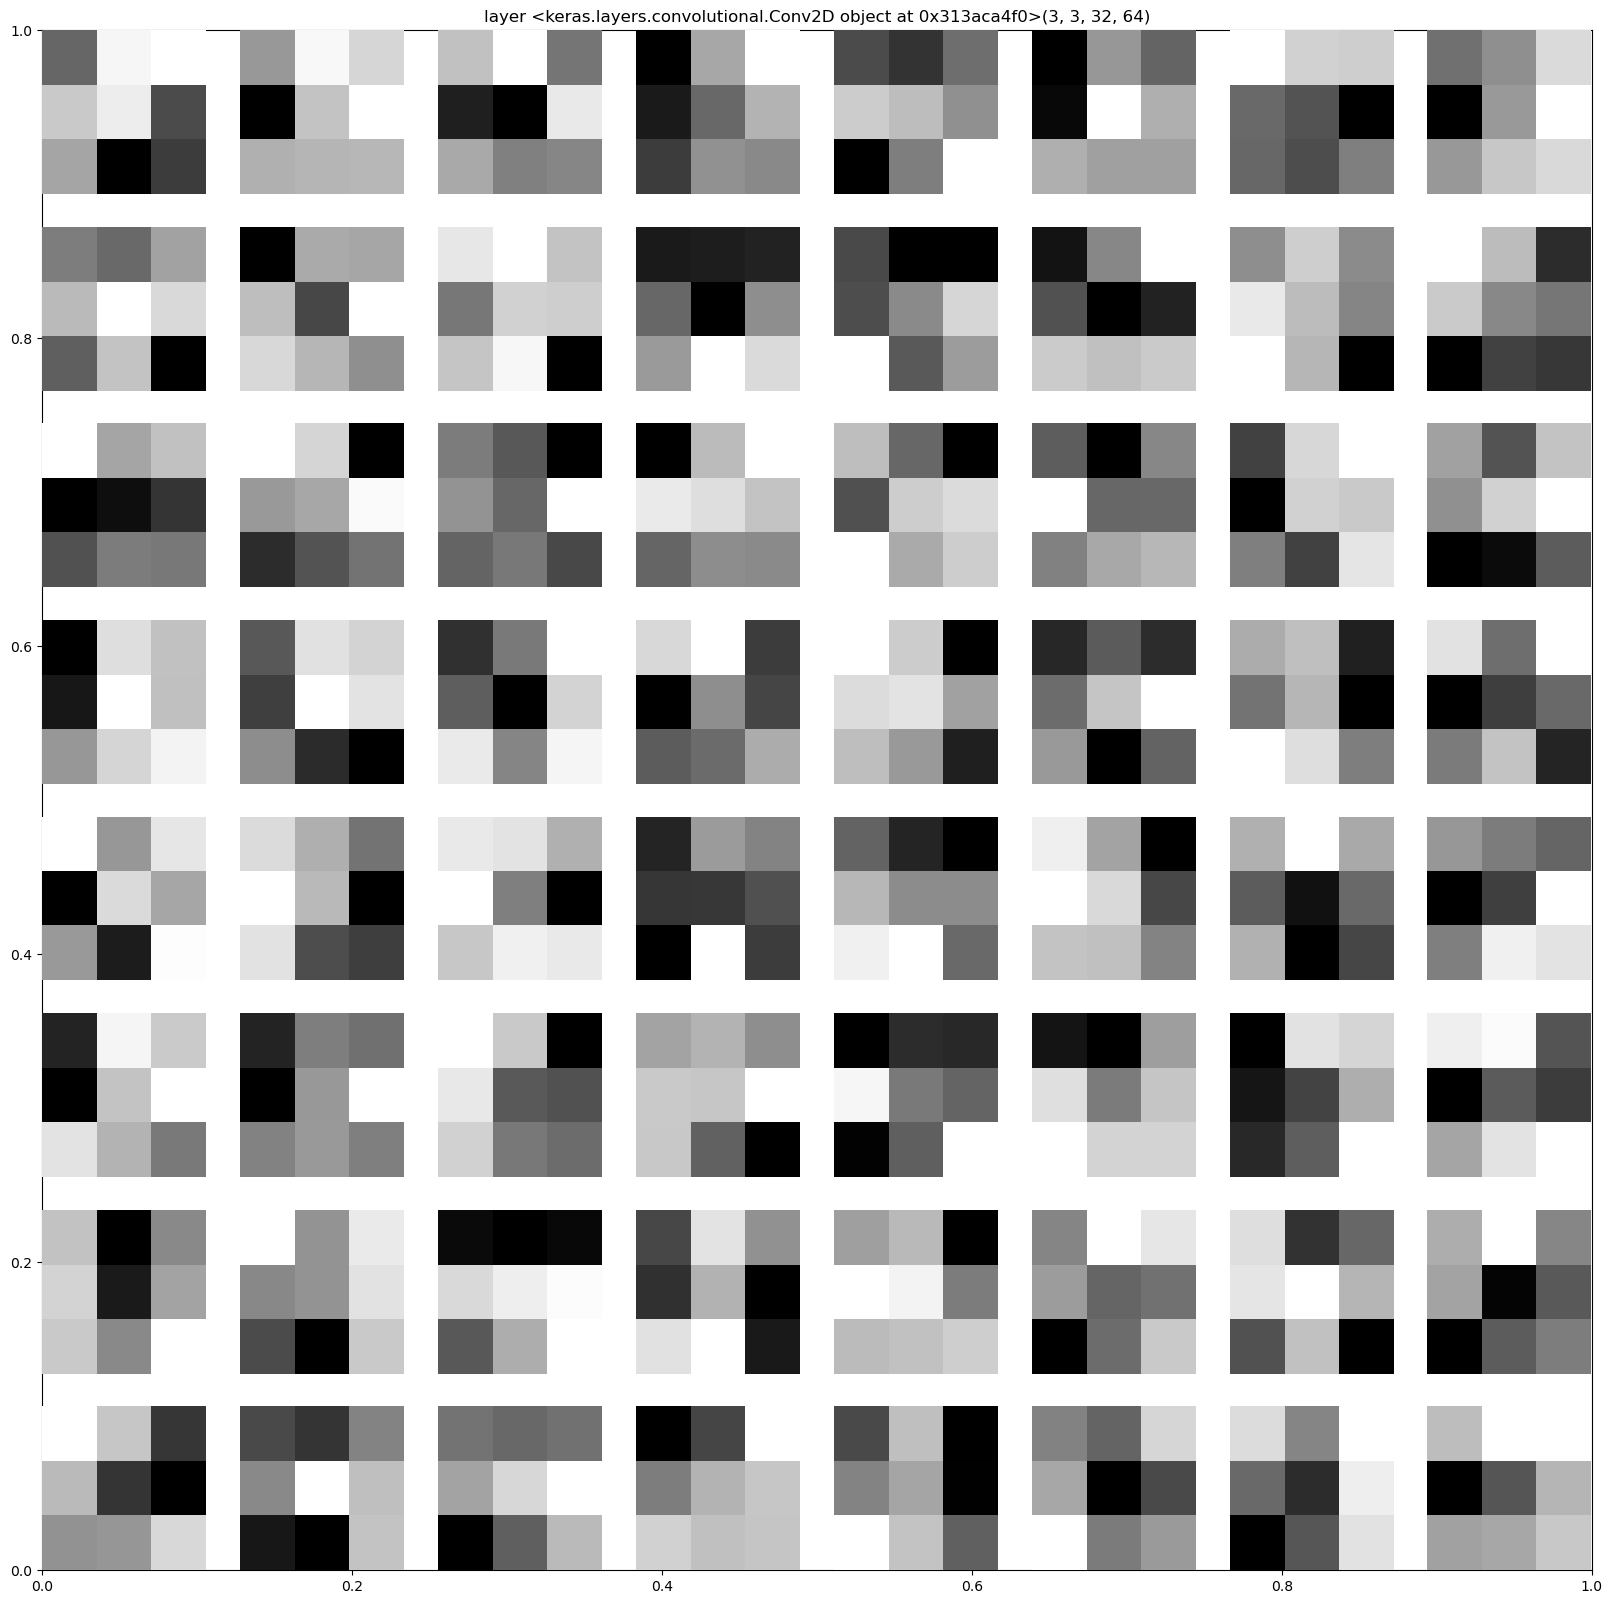

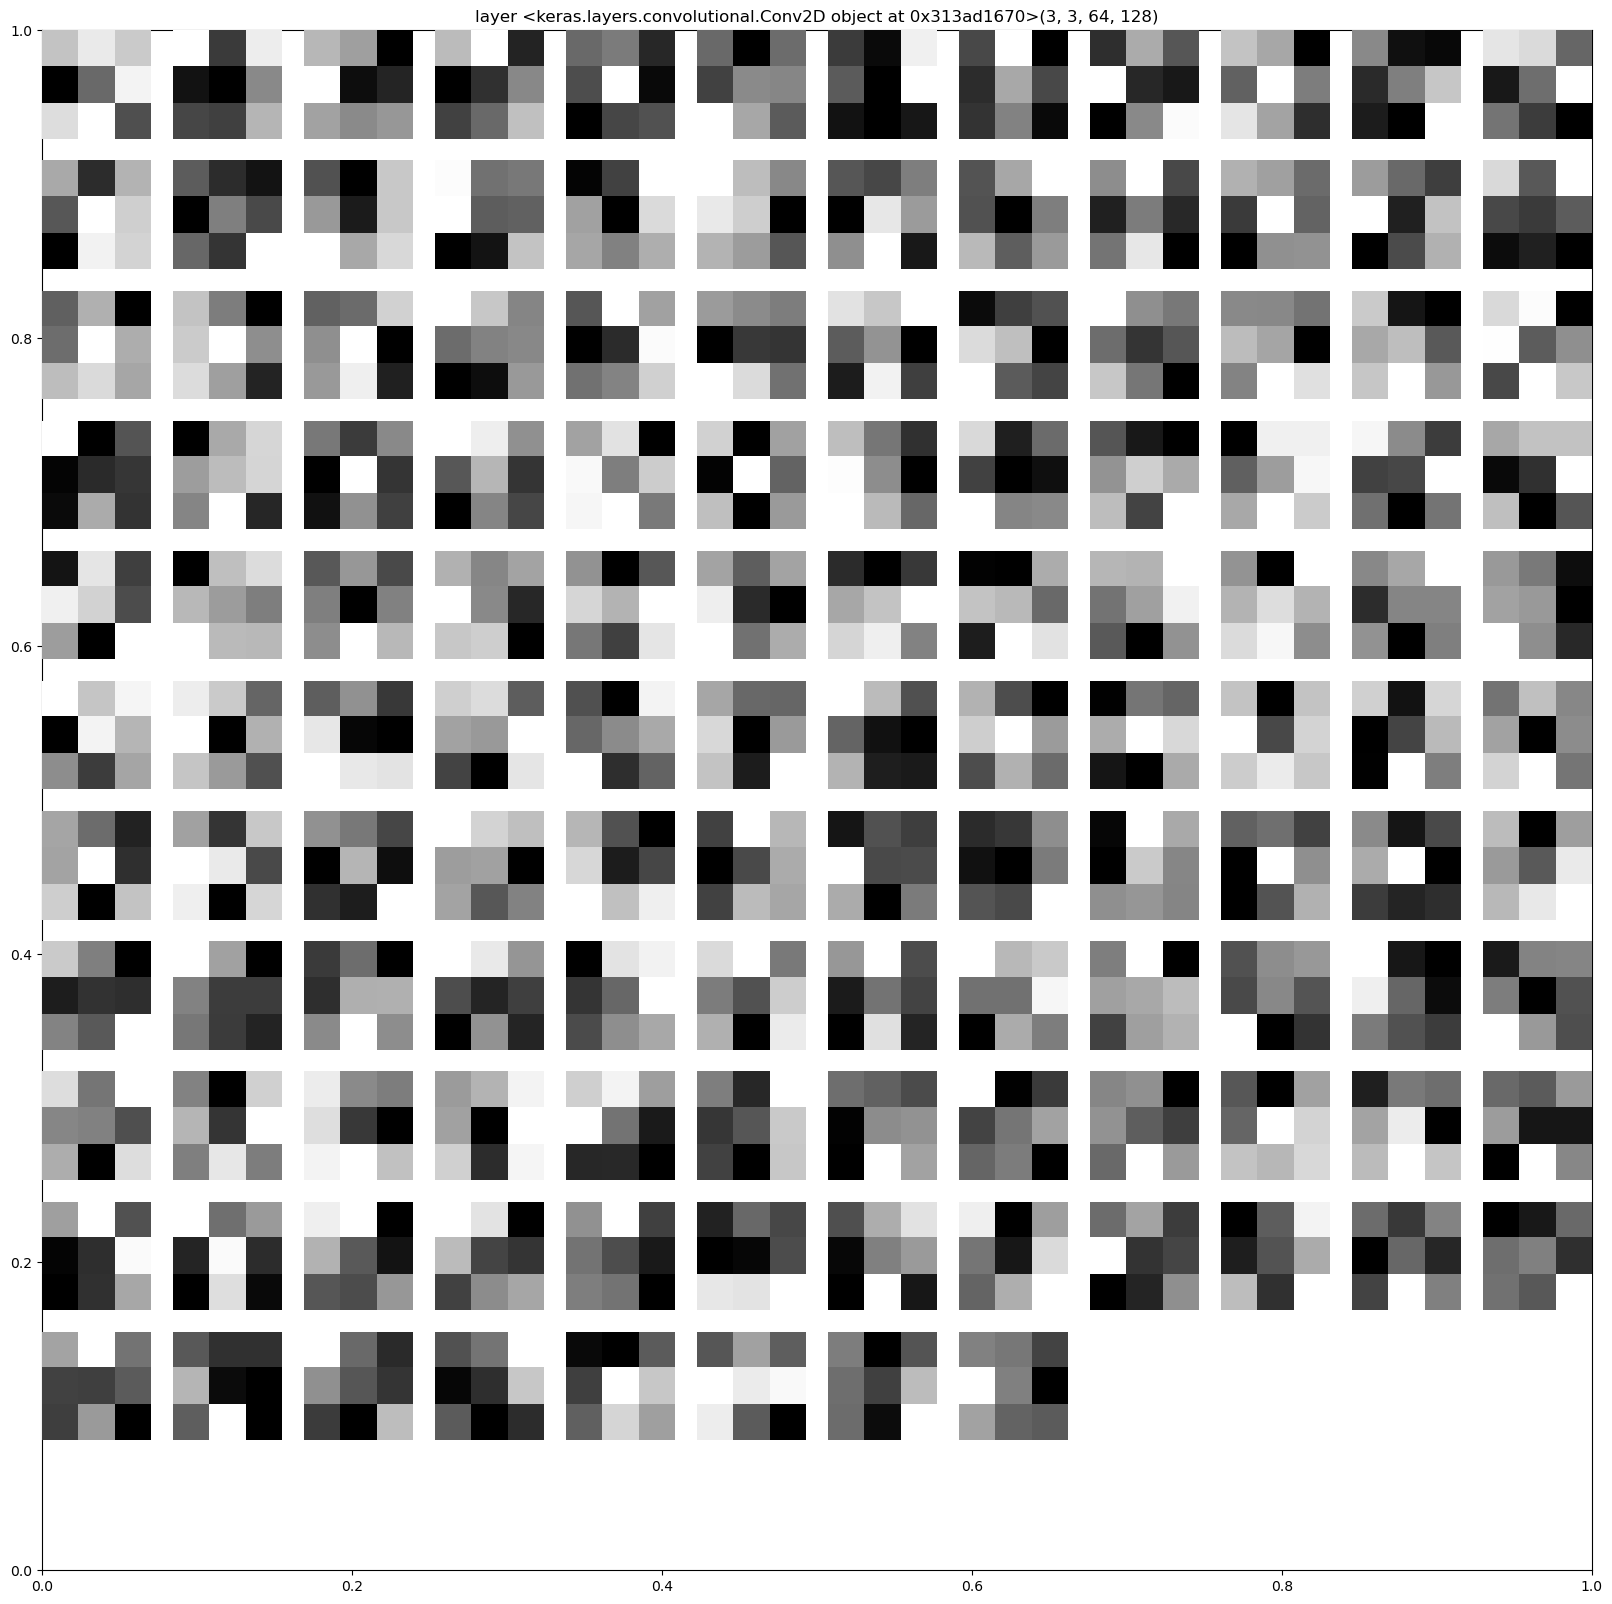

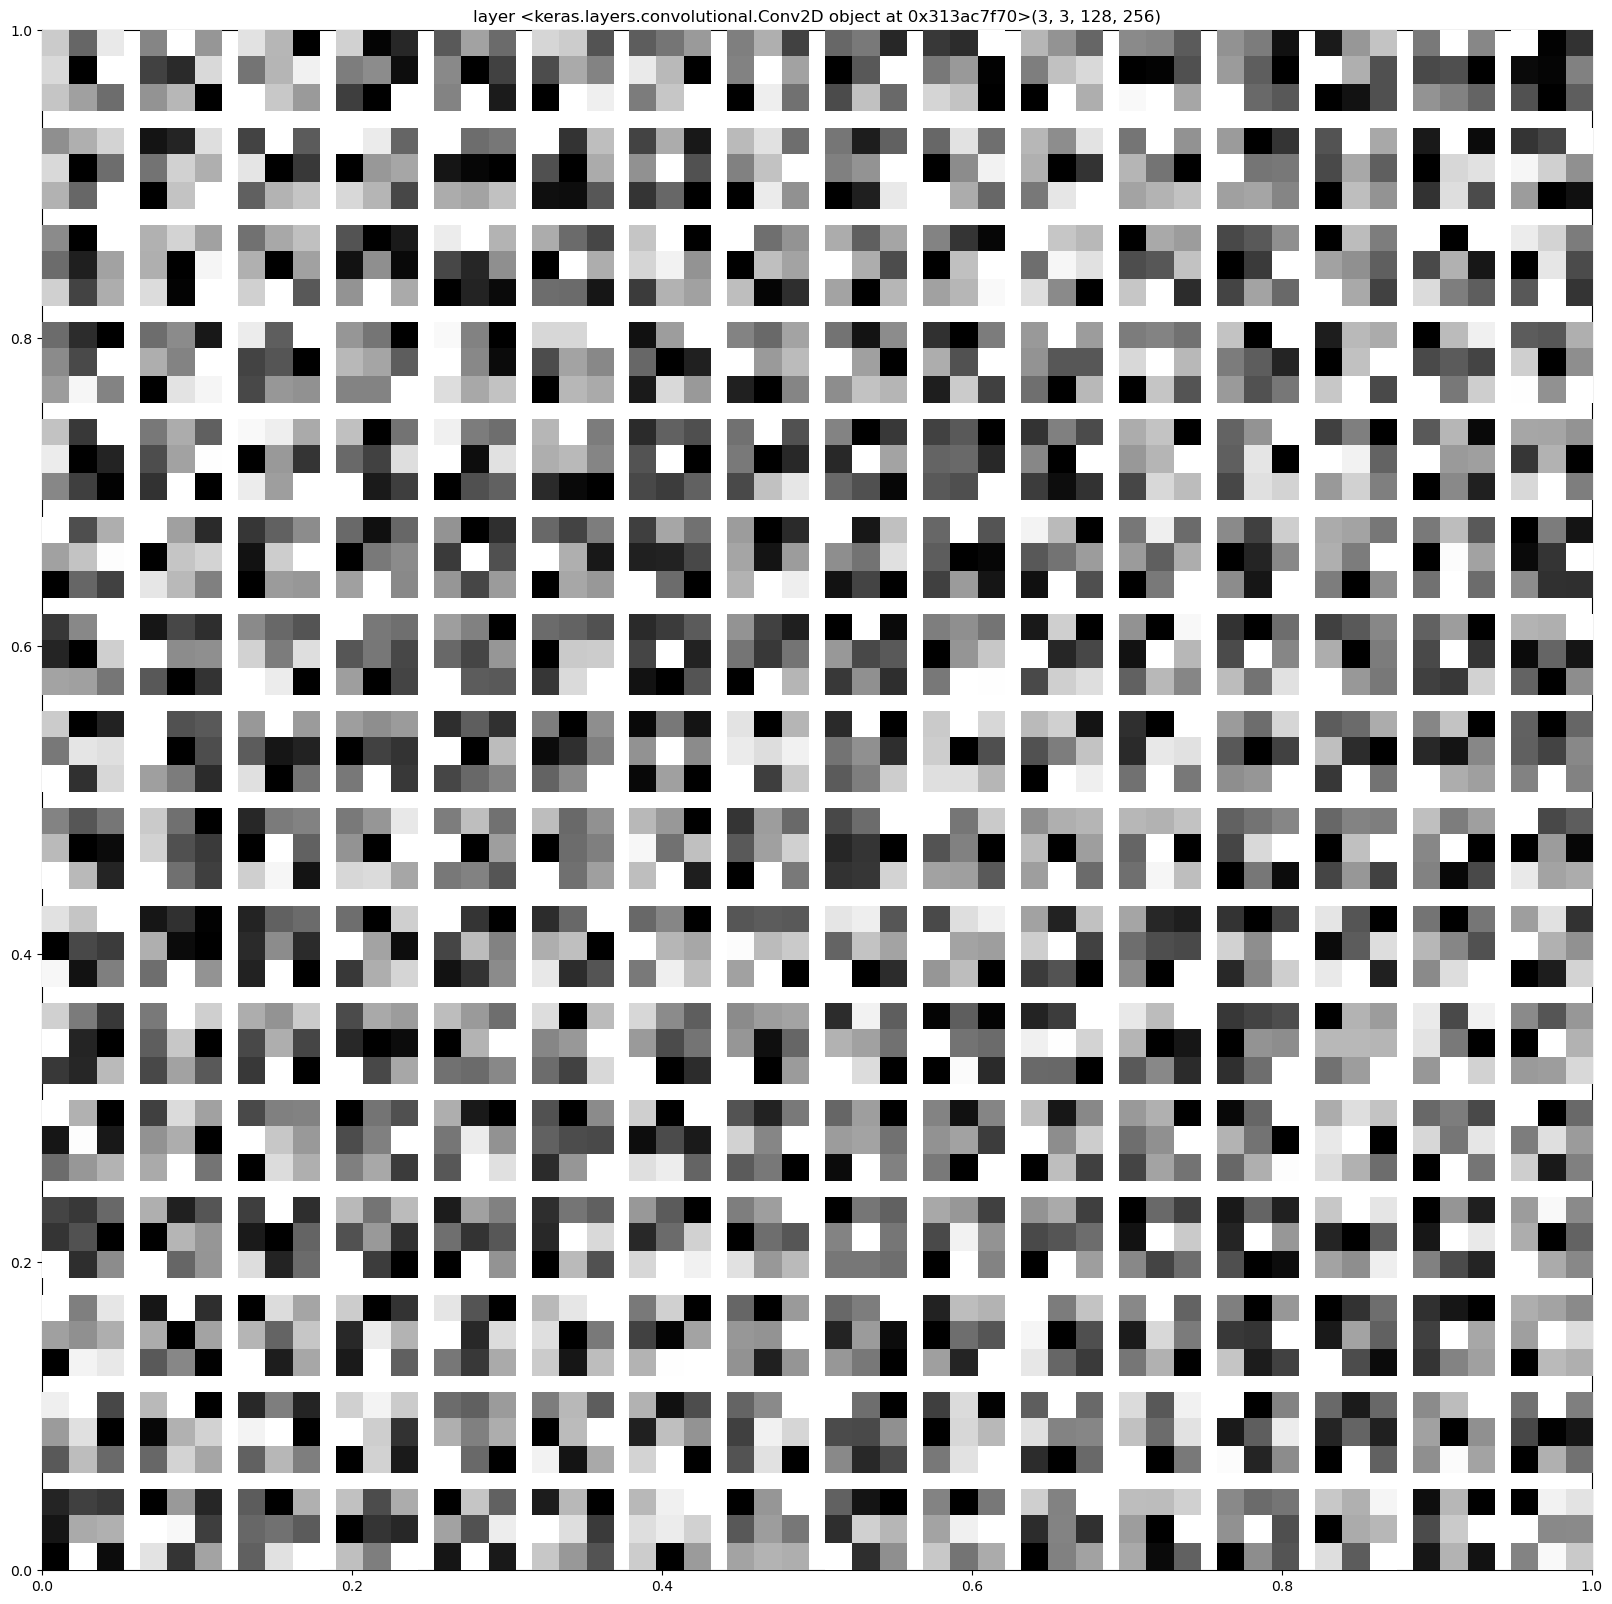

In [52]:
# print the layer weights of the model
for layer in best_model.layers:
    if 'conv' in layer.name: # do with also have to do the maxpooling layers?
        fig = plt.figure(figsize=(20,20))

        weights_n = layer.get_weights()[0]
        plt.title(str("layer "+str(layer)+str(weights_n.shape)))
        size = np.ceil(np.sqrt(weights_n.shape[3])) # size of the grid
        for filter in range(weights_n.shape[3]):
            fig.add_subplot(int(size),int(size),filter+1)
            plt.imshow(weights_n[:,:,0,filter], cmap='gray') # are there 3x3 filters of 64/ or 64 times 3x3 filters?
            plt.axis('off');

## 7) Classifying frames of videos

### 7.1) Loading the videos and generating labels

We downsampled the framerate of the video to 12 frames per second.

In [53]:
# downsample the number of frames in a video

emotions = ['anger','distgust','fear','happi','sadness','surprise','neutral']
emotion_dict = {'anger': 0, 'distgust': 1, 'fear': 2, 'happi': 3, 'sadness': 4, 'surprise': 5, 'neutral': 6}
emotion_dict_reverse = {0: 'anger', 1: 'disgust', 2: 'fear', 3: 'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

frames_louis = []
labels_louis = []
for e in emotions:
    path = 'videos/'+e+'.avi'
    cap = cv2.VideoCapture(path)
    count = 0
    while cap.isOpened():
        success,image = cap.read()
        if not success: break
        img_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        img = cv2.resize(img_gray,(48,48))
        img = np.expand_dims(img,axis=-1)
        frames_louis.append(img)
        labels_louis.append(emotion_dict[e])

labels_one_hot_encoded = [one_hot_encoder(label, num_labels=7) for label in labels_louis]
labels_strings = [emotion_dict_reverse[label] for label in labels_louis]
frames_louis = np.array(frames_louis)
labels_one_hot_encoded = np.array(labels_one_hot_encoded)

Dimension of labels: (129, 7)


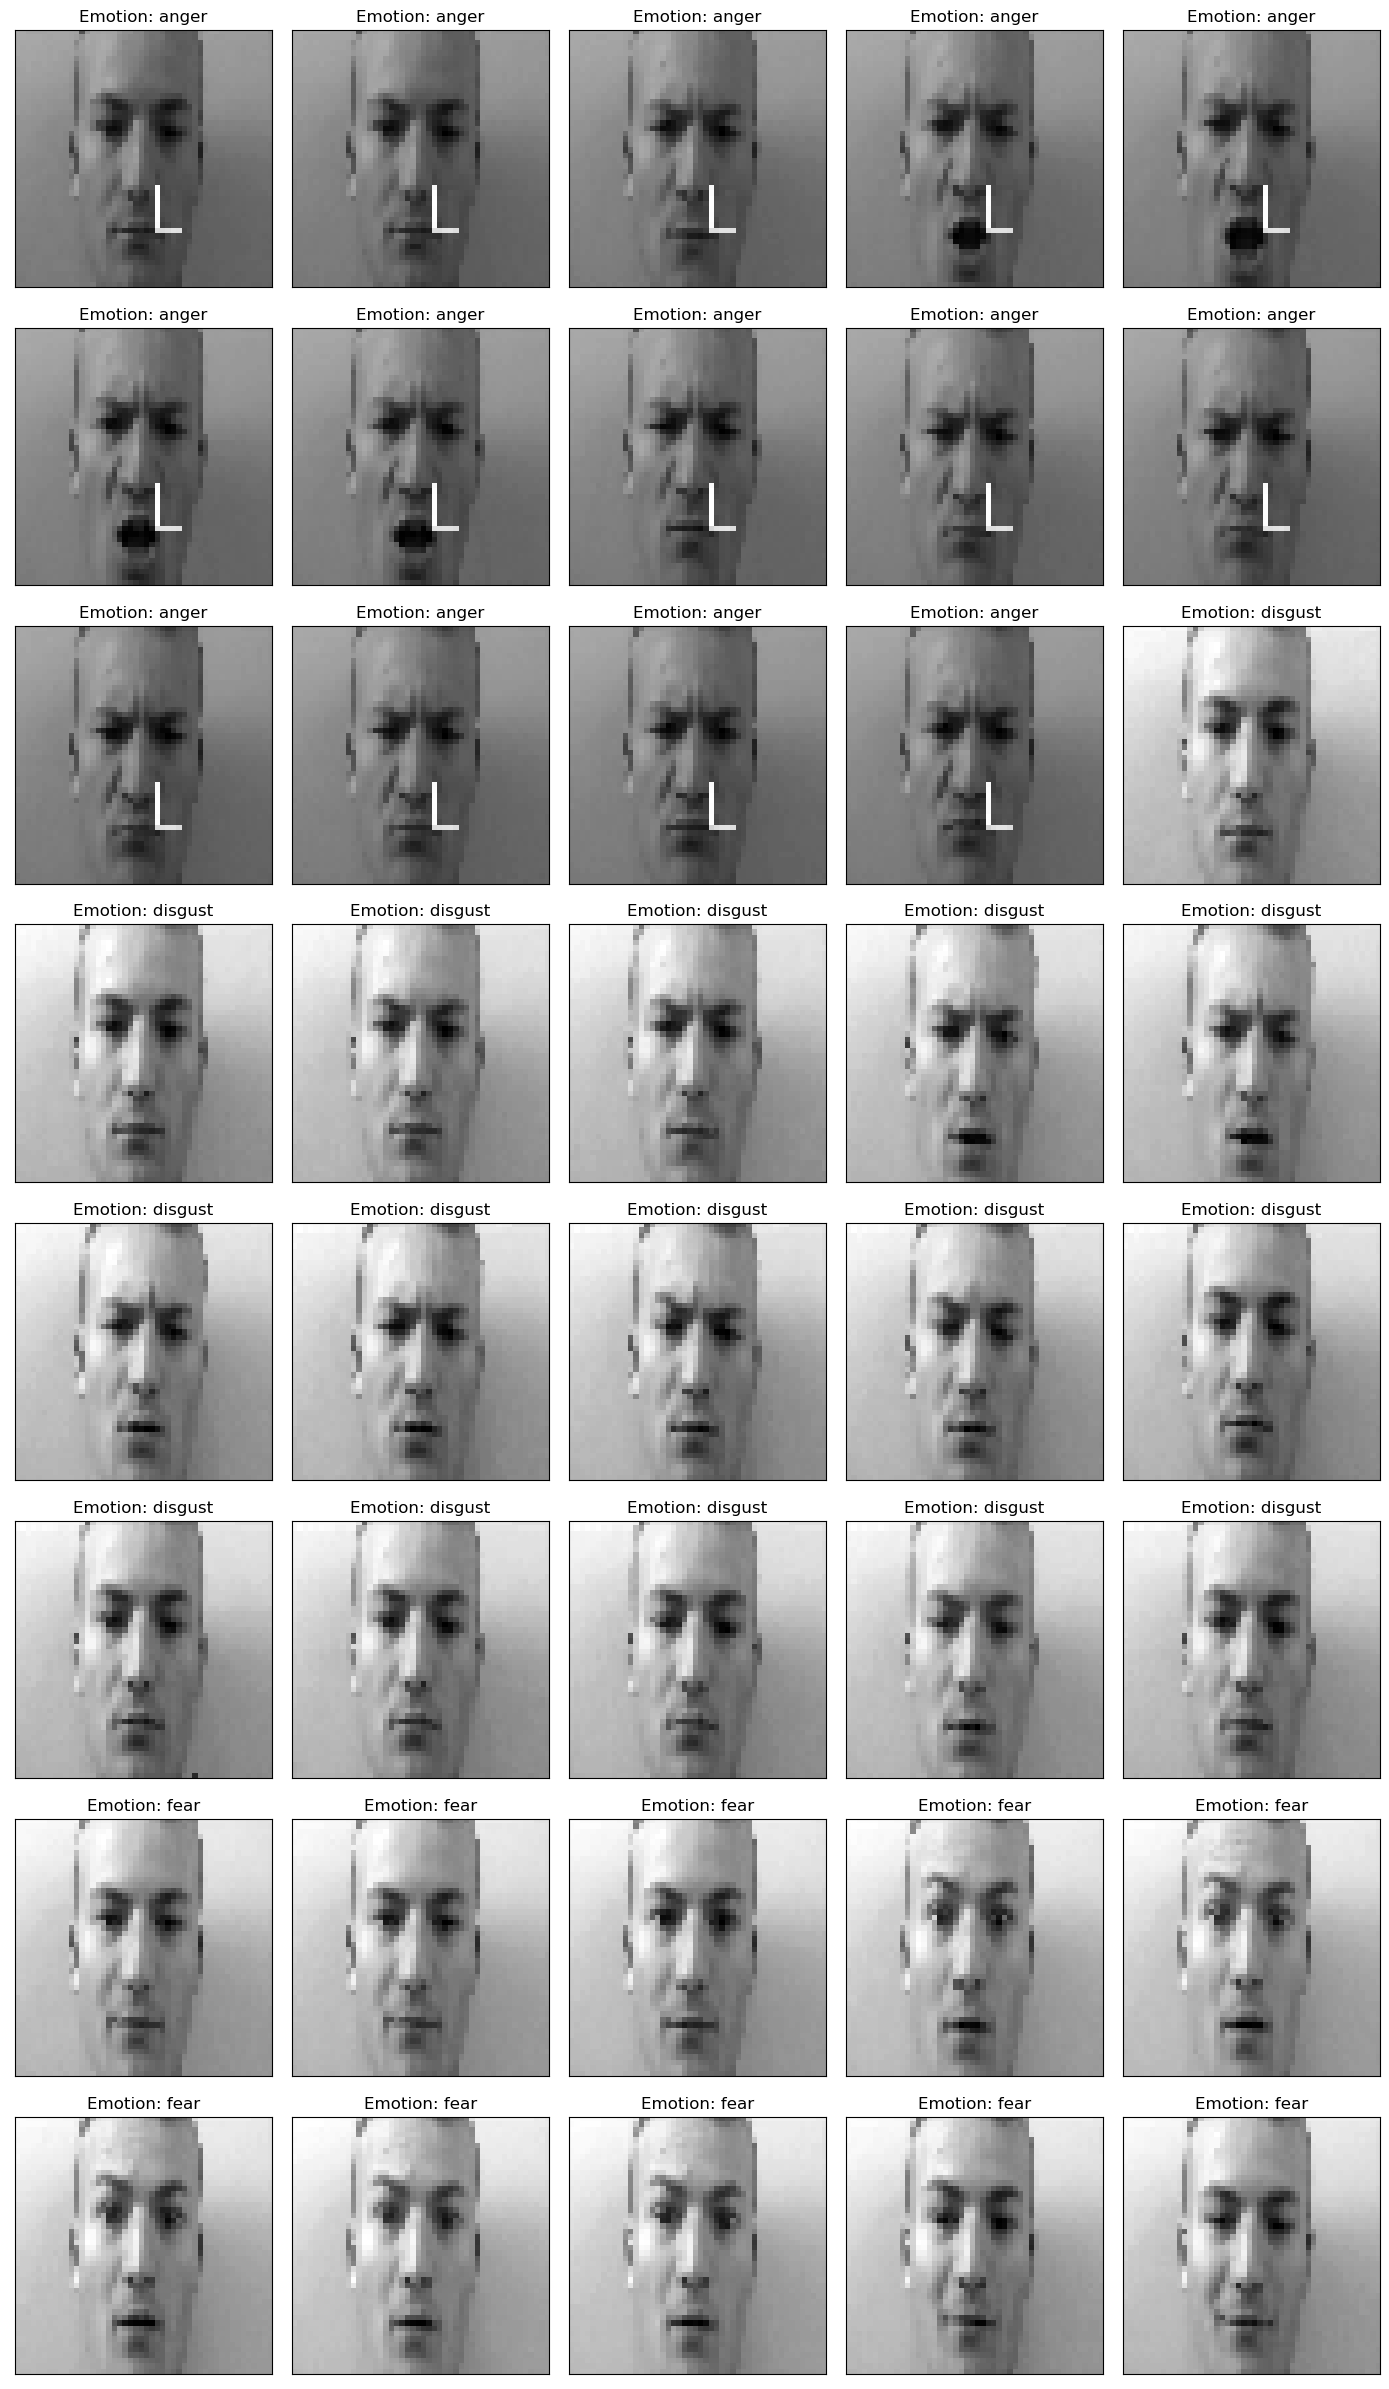

In [54]:
# printing some of the frames as an example

print(f'Dimension of labels: {labels_one_hot_encoded.shape}')

fig = plt.figure(figsize=(14, 24))
for i in range(40):
    ax = plt.subplot(8, 5, i+1)
    ax.imshow(frames_louis[i], cmap='gray')
    ax.set_title(f'Emotion: {emotion_dict_reverse[labels_louis[i]]}')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

### 7.2) Evaluating the model on the frames

Scores of the final model
Test accuracy: 0.248062
     emotion  precision    recall
0      anger   1.000000  0.285714
1    disgust   0.000000  0.000000
2       fear   0.173913  0.666667
3  happiness   0.000000  0.000000
4    sadness   0.000000  0.000000
5   surprise   0.180556  1.000000
6    neutral   1.000000  0.233333


/Users/thomasbahne/Programmieren/miniforge3/envs/DLpy39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


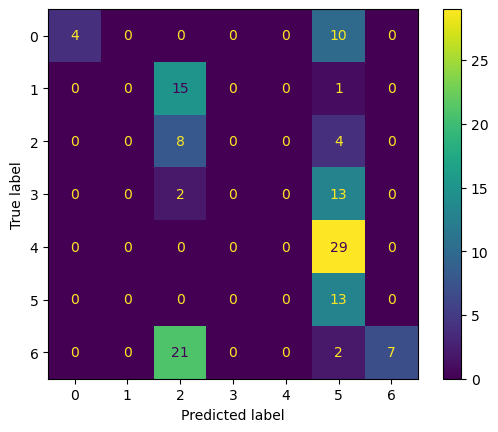

In [62]:
frame_probabilites_louis = best_model.predict(frames_louis)
frame_predictions_louis = np.argmax(frame_probabilites_louis, axis=1)

frames_accuracy = np.round(accuracy_score(y_true=labels_louis, y_pred=frame_predictions_louis), 6)
frames_precision = precision_score(labels_louis, frame_predictions_louis, average=None)
frames_recall = recall_score(labels_louis, frame_predictions_louis, average=None)

df_frames_prec_recall = pd.DataFrame({'emotion': ['anger','disgust','fear','happiness','sadness','surprise','neutral'],
                                'precision': frames_precision, 'recall': frames_recall})

print('Scores of the final model')
print(f'Test accuracy: {frames_accuracy}')
print(df_frames_prec_recall)

conf_matrix = confusion_matrix(y_true=labels_louis, y_pred=frame_predictions_louis)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot();